<a href="https://colab.research.google.com/github/ealeongomez/GuajiraSustainableWindBot/blob/develop/test/smoke/RNN_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preliminares**

## **Packages**

In [1]:
!git clone https://github.com/ealeongomez/GuajiraSustainableWindBot.git

Cloning into 'GuajiraSustainableWindBot'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 85 (delta 23), reused 67 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 8.97 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [2]:
%cd GuajiraSustainableWindBot
!git fetch origin
!git checkout develop

/content/GuajiraSustainableWindBot
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'


In [3]:
!pip install tabulate

In [4]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import os, pickle, re, pickle
from zipfile import ZipFile
from warnings import filterwarnings
from tabulate import tabulate

# Machine learning packages
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow import keras

# Performance metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

filterwarnings('ignore')

## Variables

In [5]:
window = 50                # Size of array
predictionHorizonMax = 12  # Maximum prediction horizon
neurons = 32               # Number of neurons in LSTM
epochs = 100               # Number of epochs
batch_size = 128           # Batch size

## **Functions**

In [6]:
def SerieMatriz(timeSerie, predictionHorizonMax, window):
  timeSerie = np.squeeze(timeSerie)

  X = np.zeros([len(timeSerie)-predictionHorizonMax-window+1, window])
  y = np.zeros([len(timeSerie)-predictionHorizonMax-window+1, predictionHorizonMax])
  for i in range(X.shape[0]):
      X[i,:] = timeSerie[i:i+window]
      y[i,:] = timeSerie[i+window: i+window+predictionHorizonMax]

  return X, np.squeeze(y)

In [7]:
def r2_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res/(SS_tot + keras.backend.epsilon())

# **Read datasets**

================================================ la_jagua_del_pilar


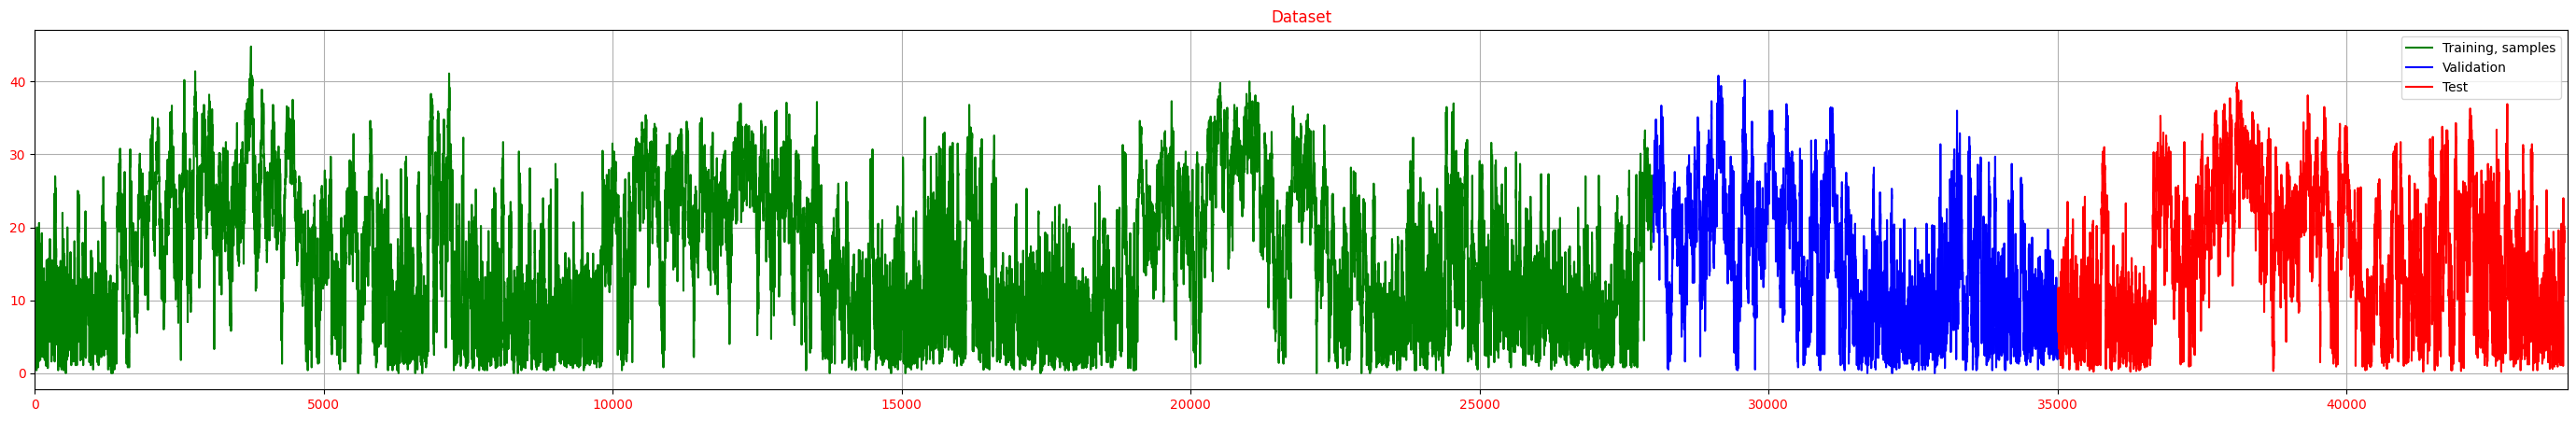

================================================ maicao


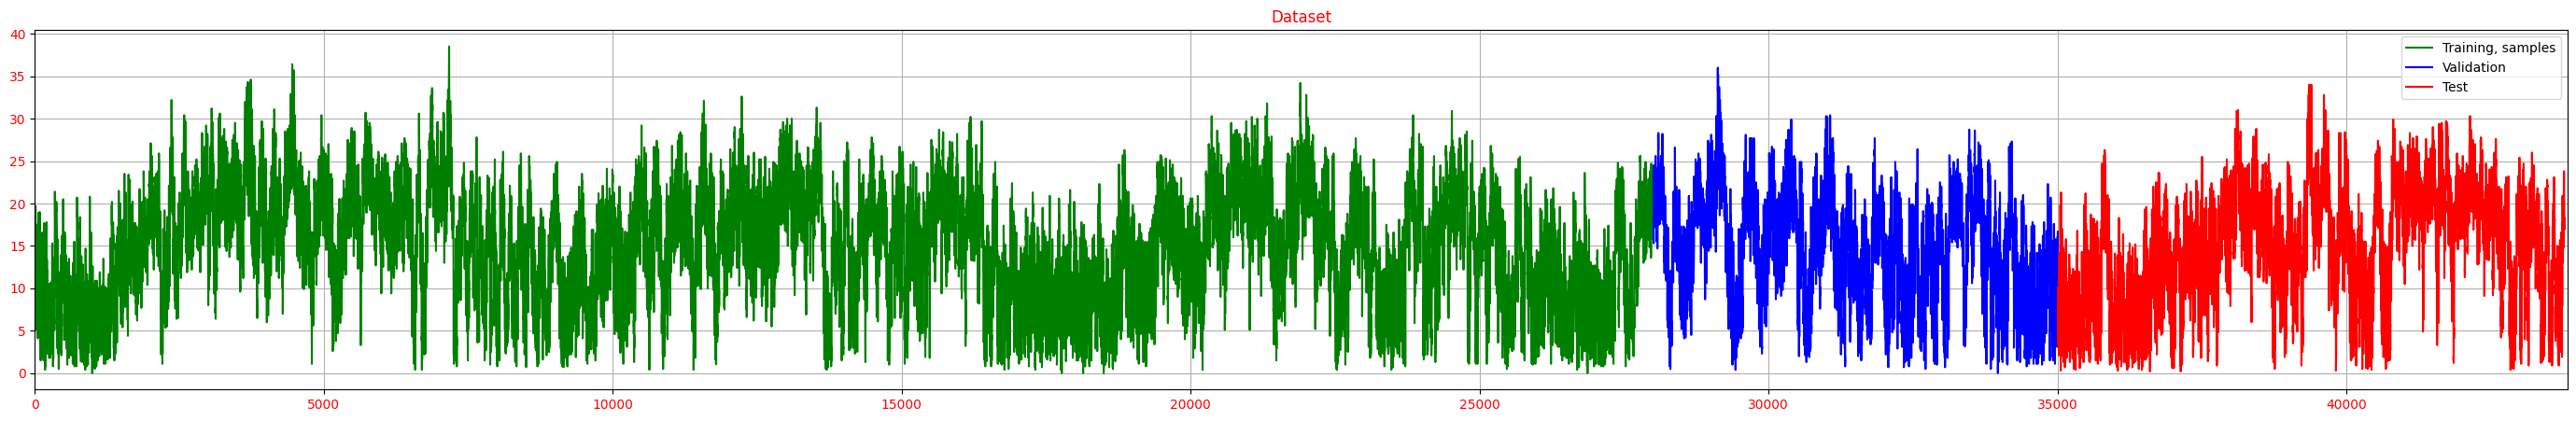

================================================ mingueo


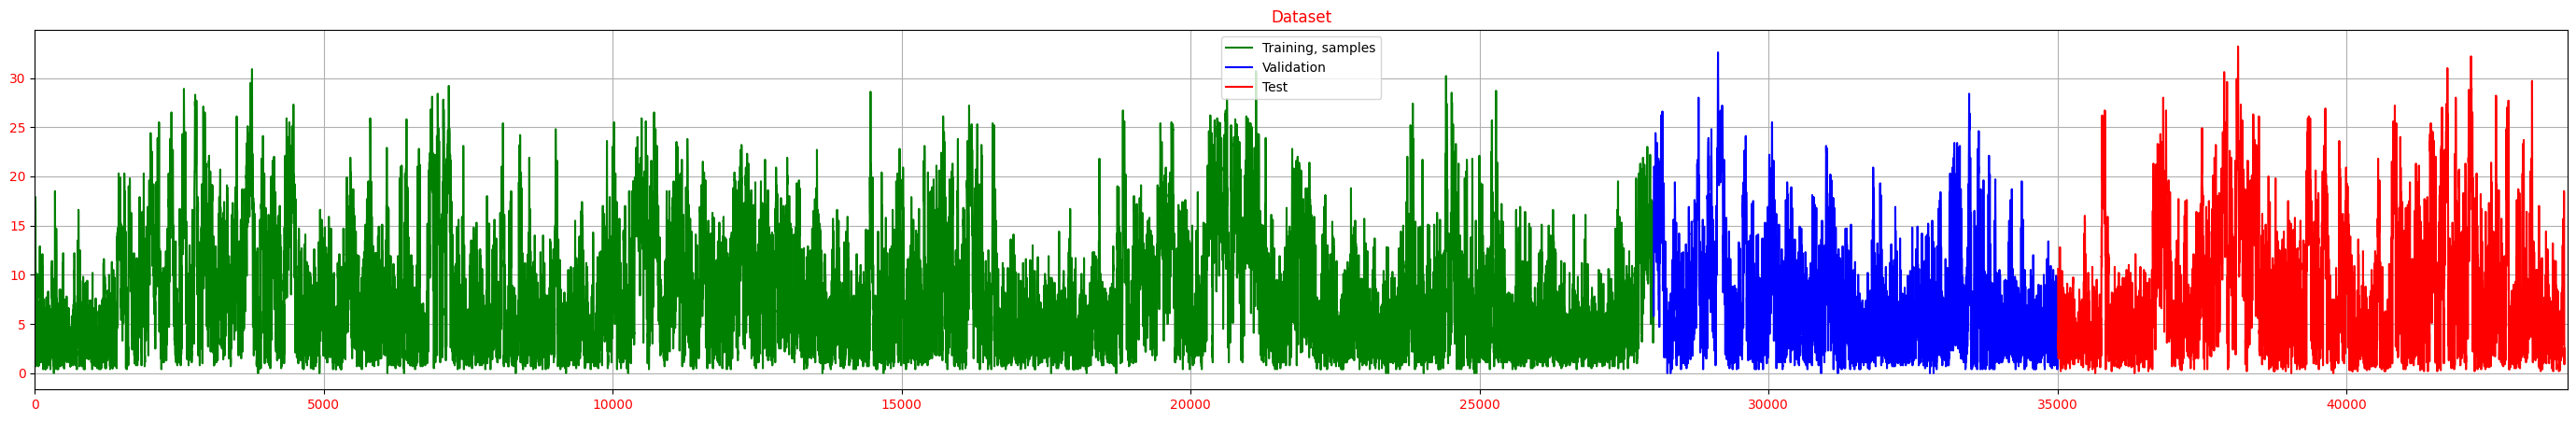

================================================ hatonuevo


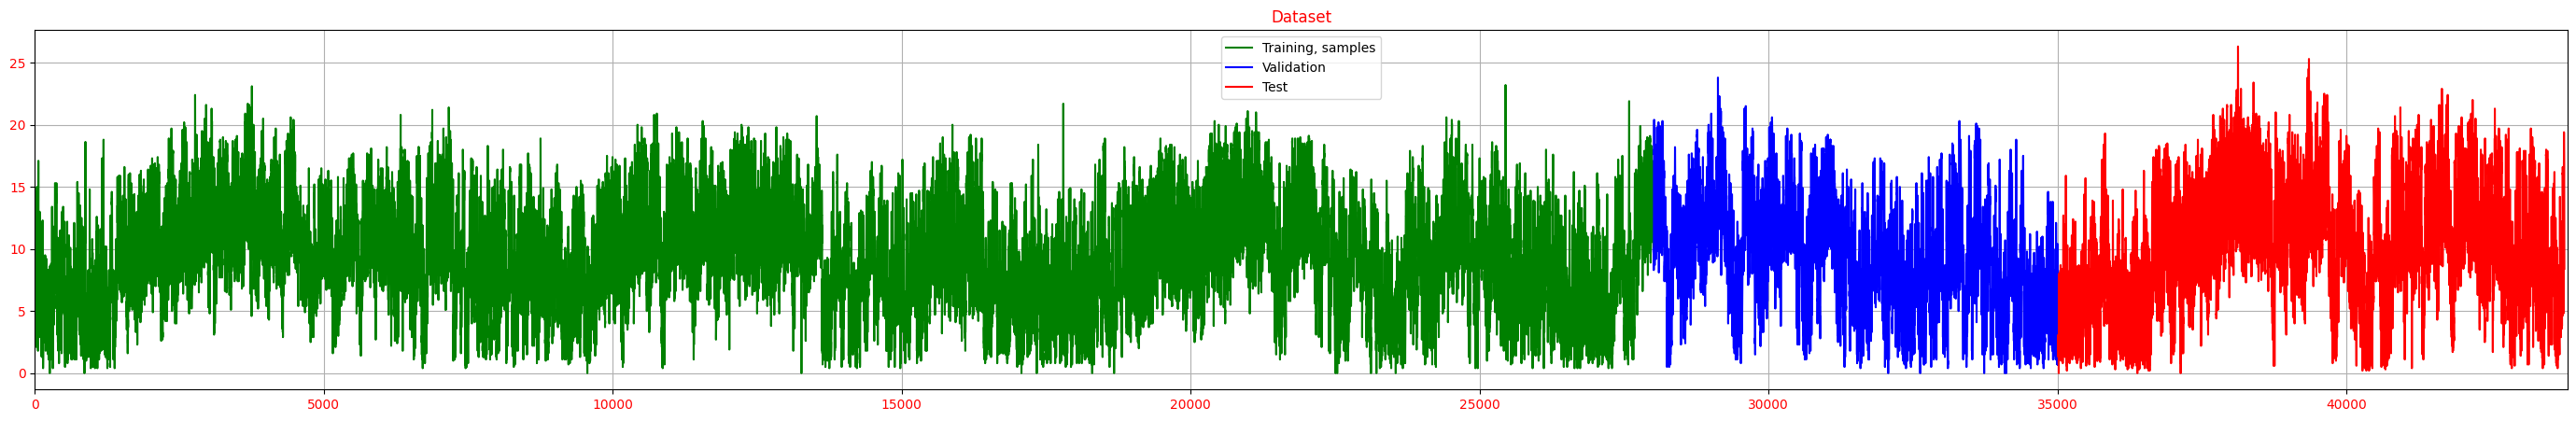

================================================ el_molino


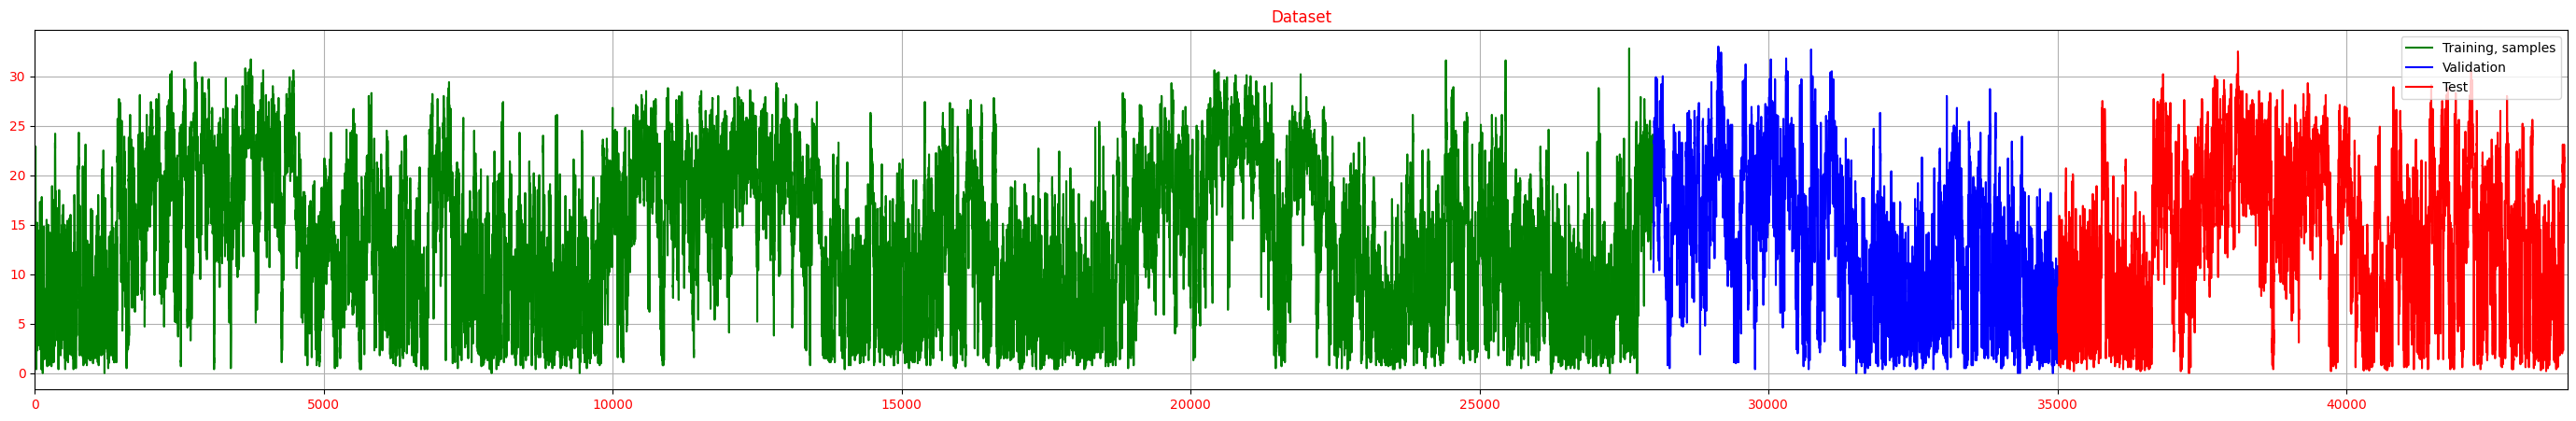

================================================ manaure


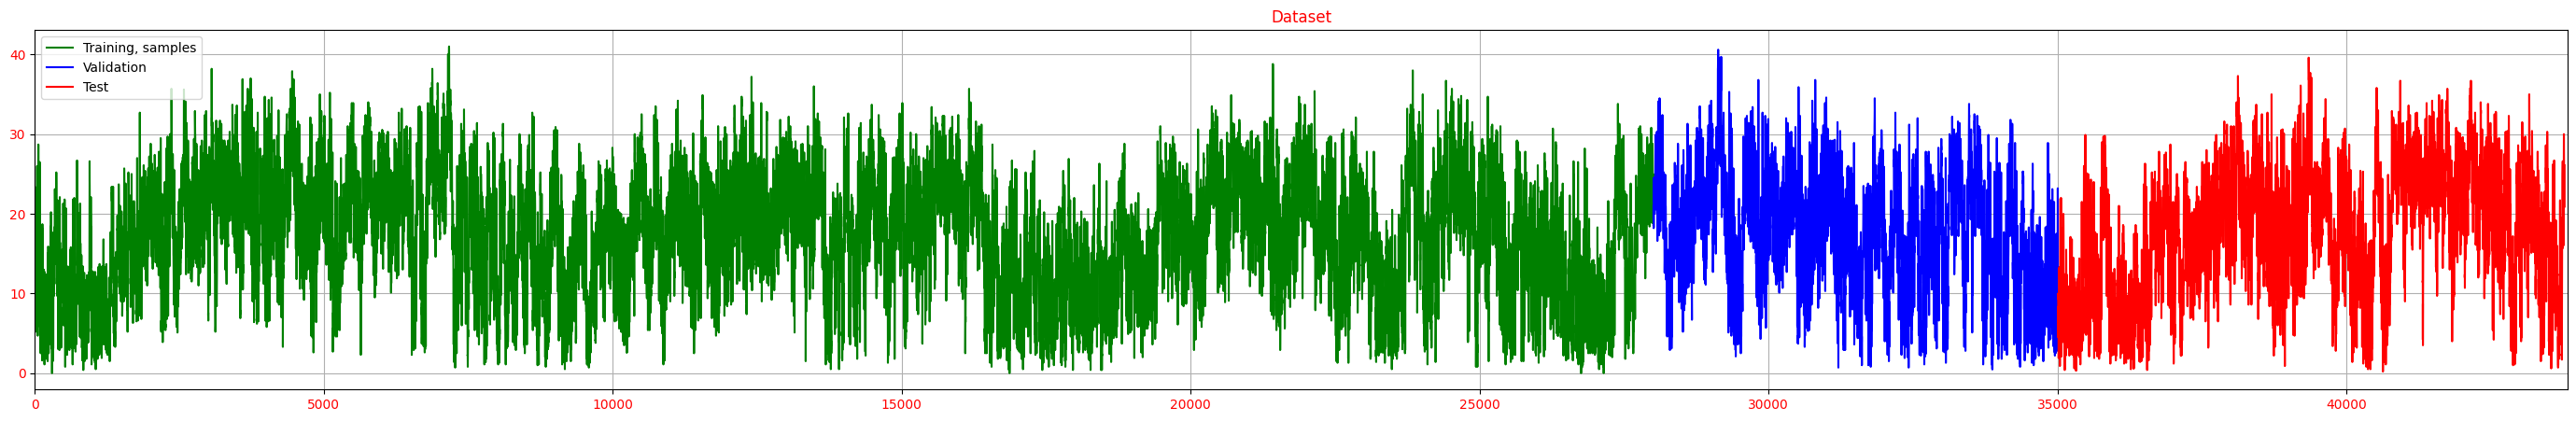

================================================ barrancas


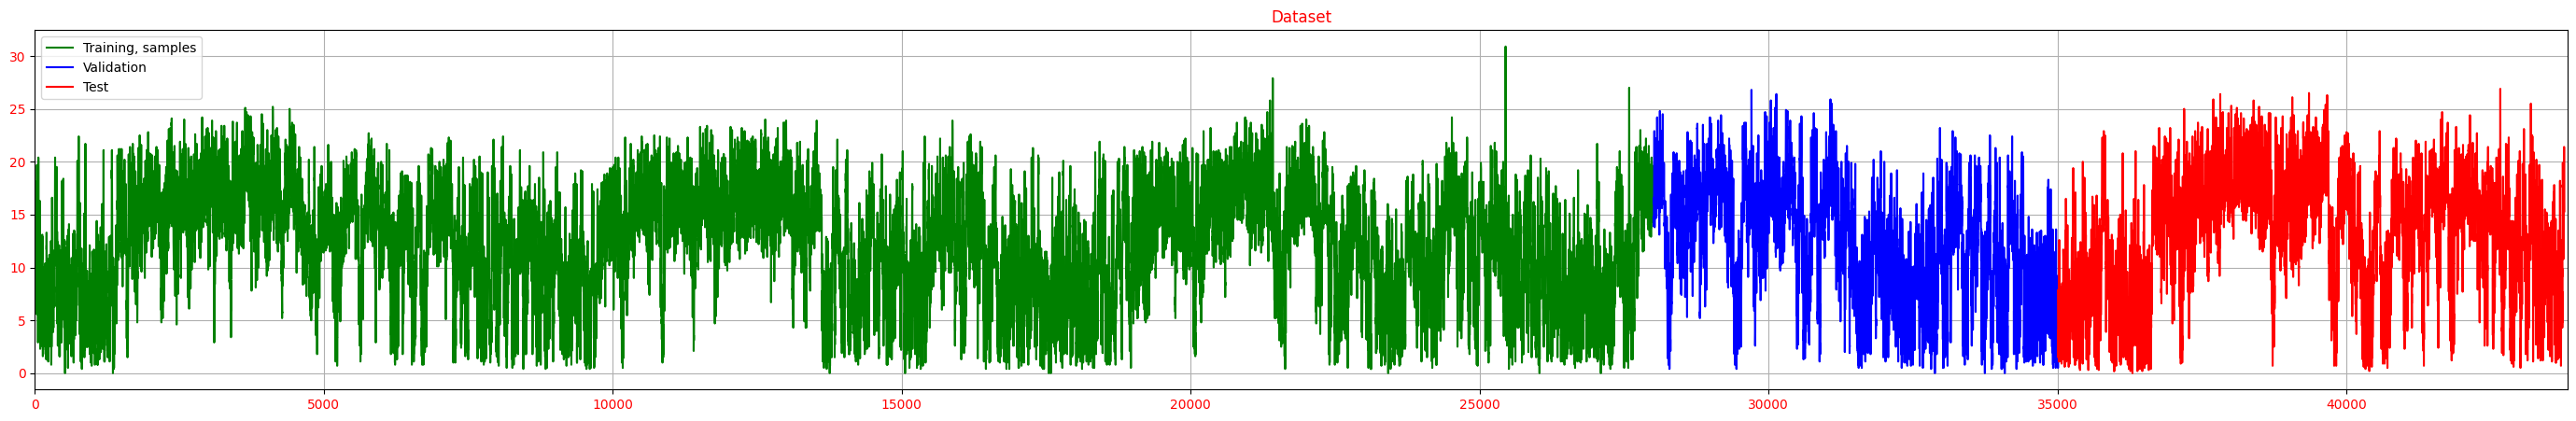

================================================ uribia


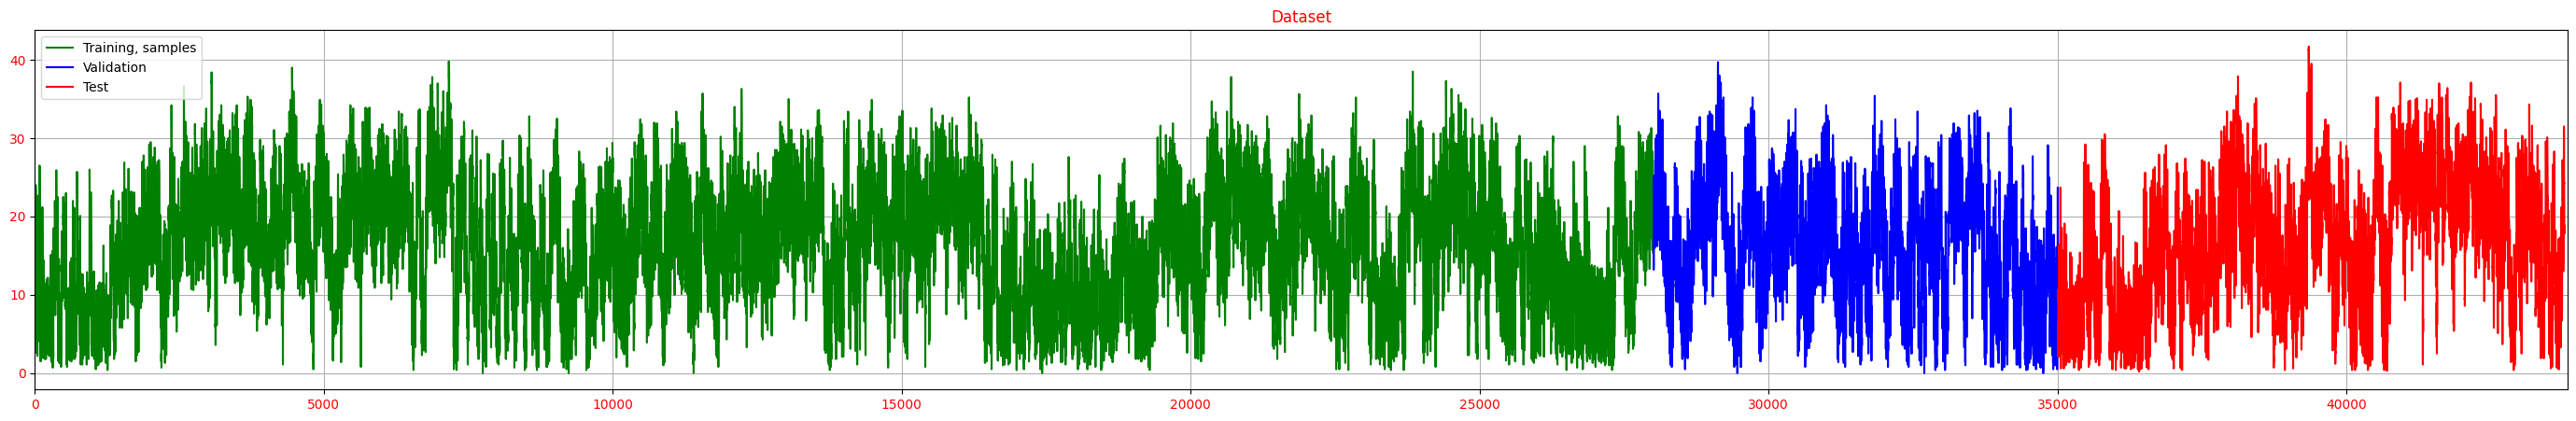

================================================ distraccion


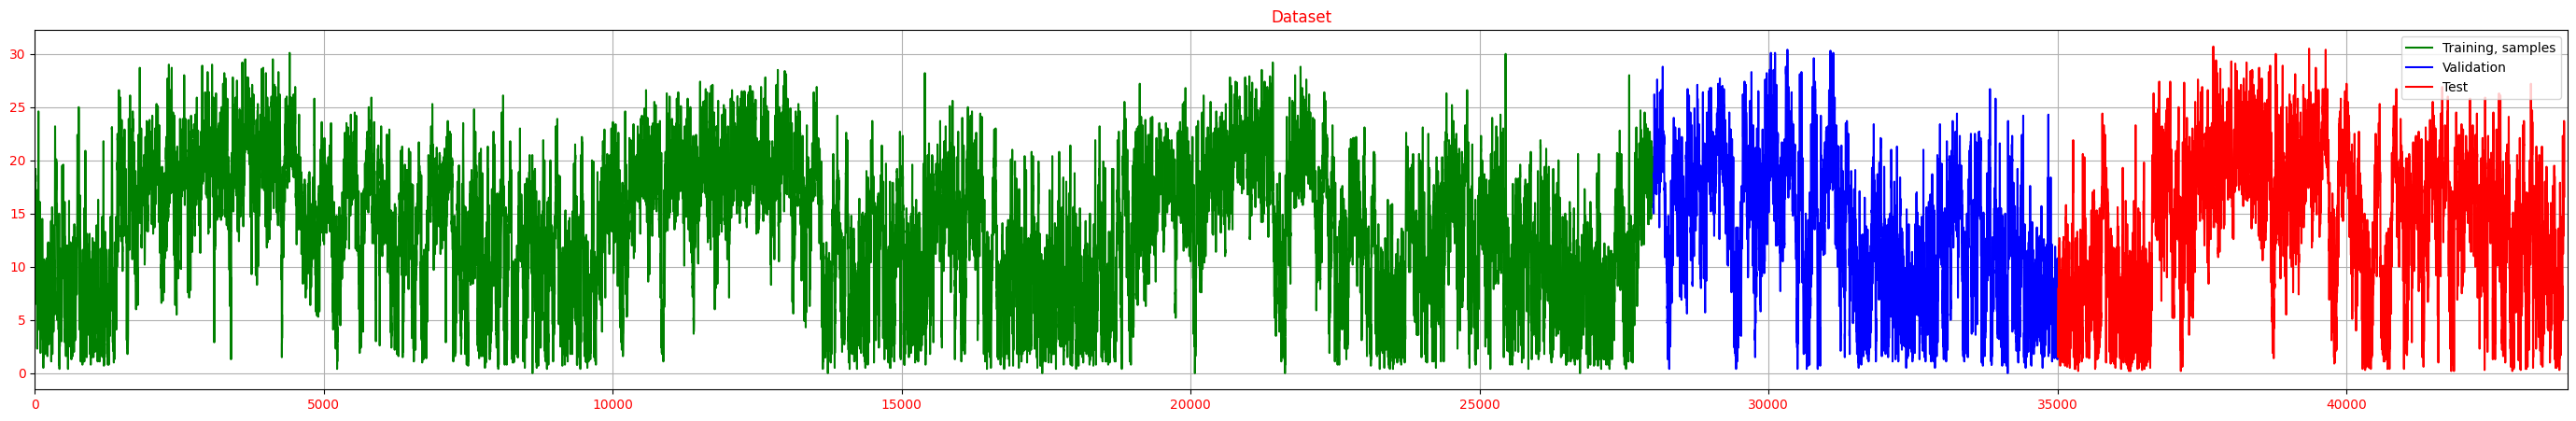

================================================ san_juan_del_cesar


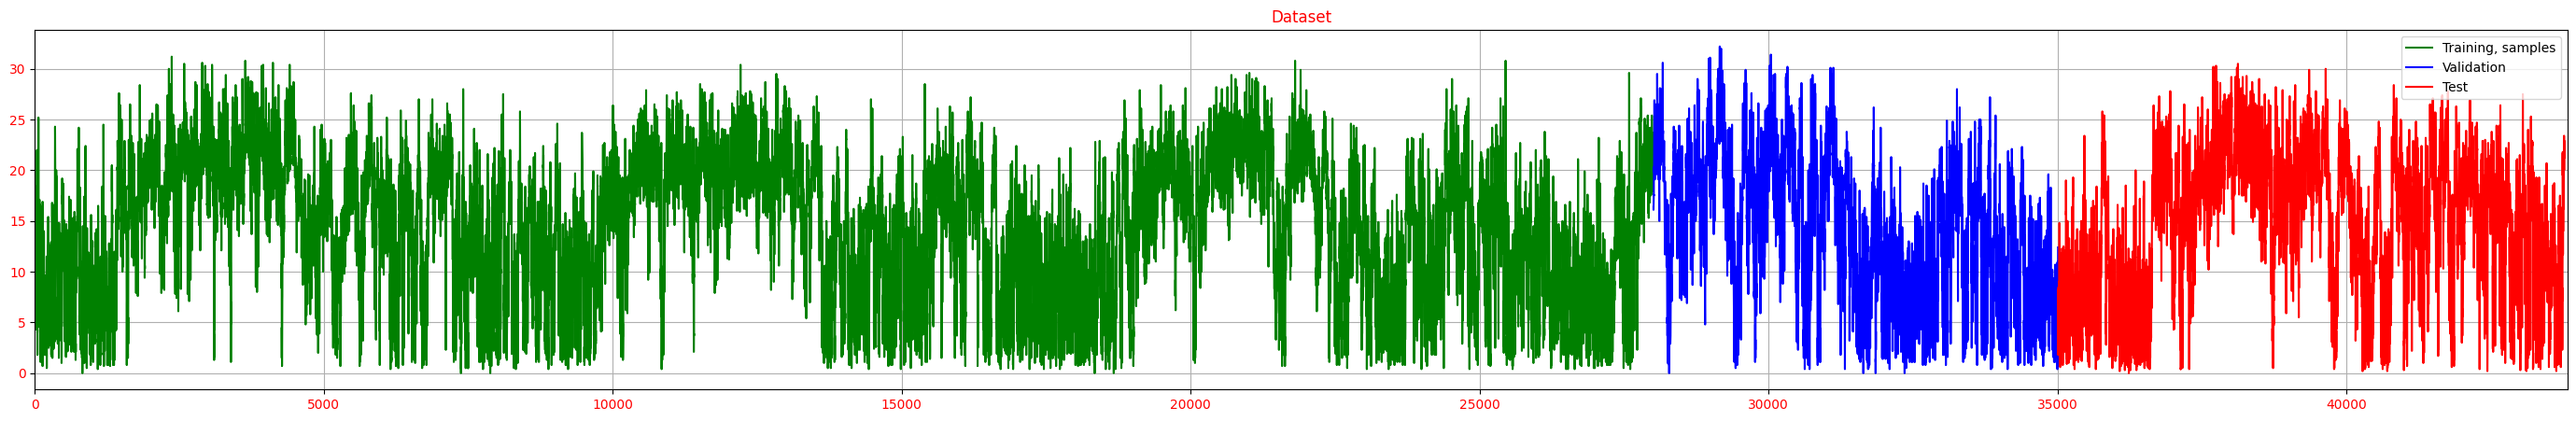

================================================ albania


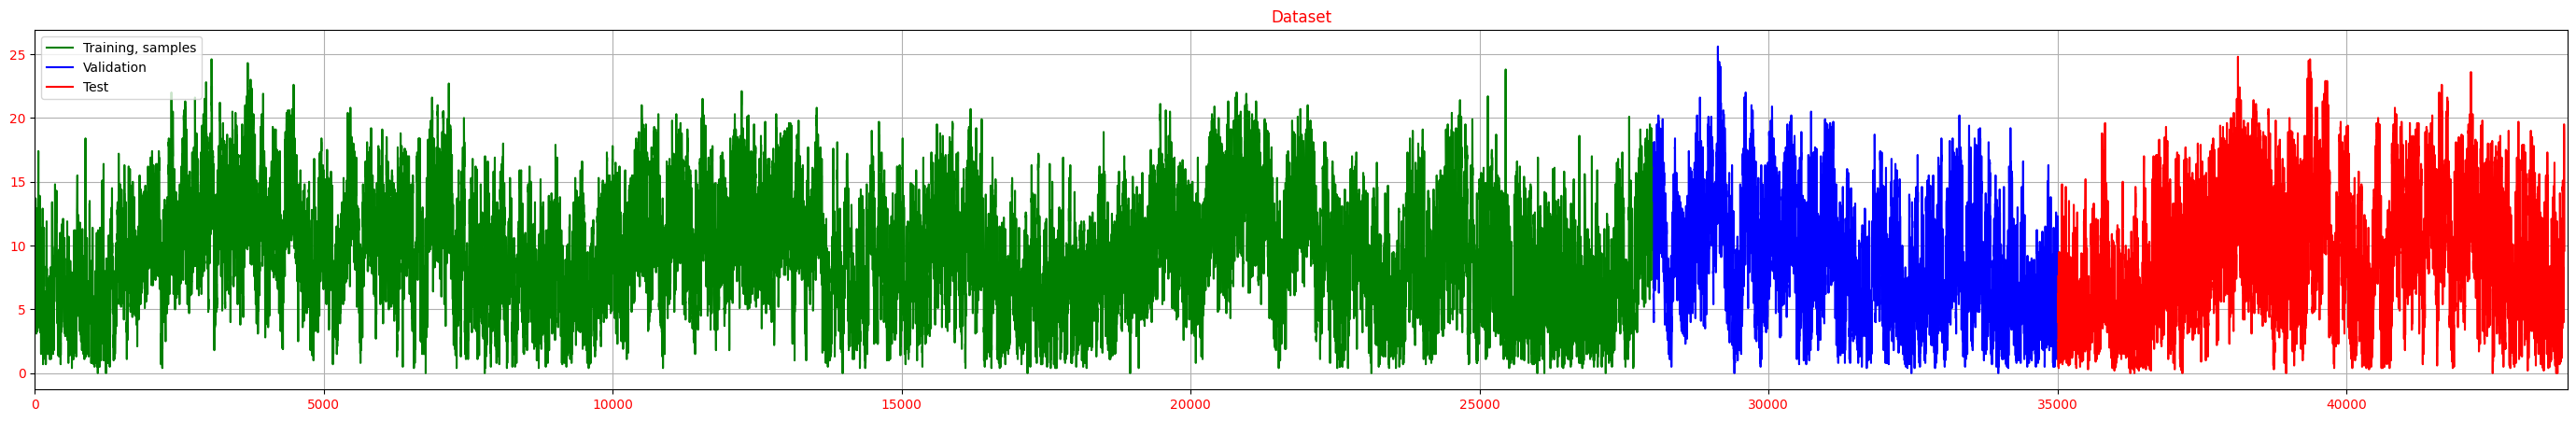

================================================ riohacha


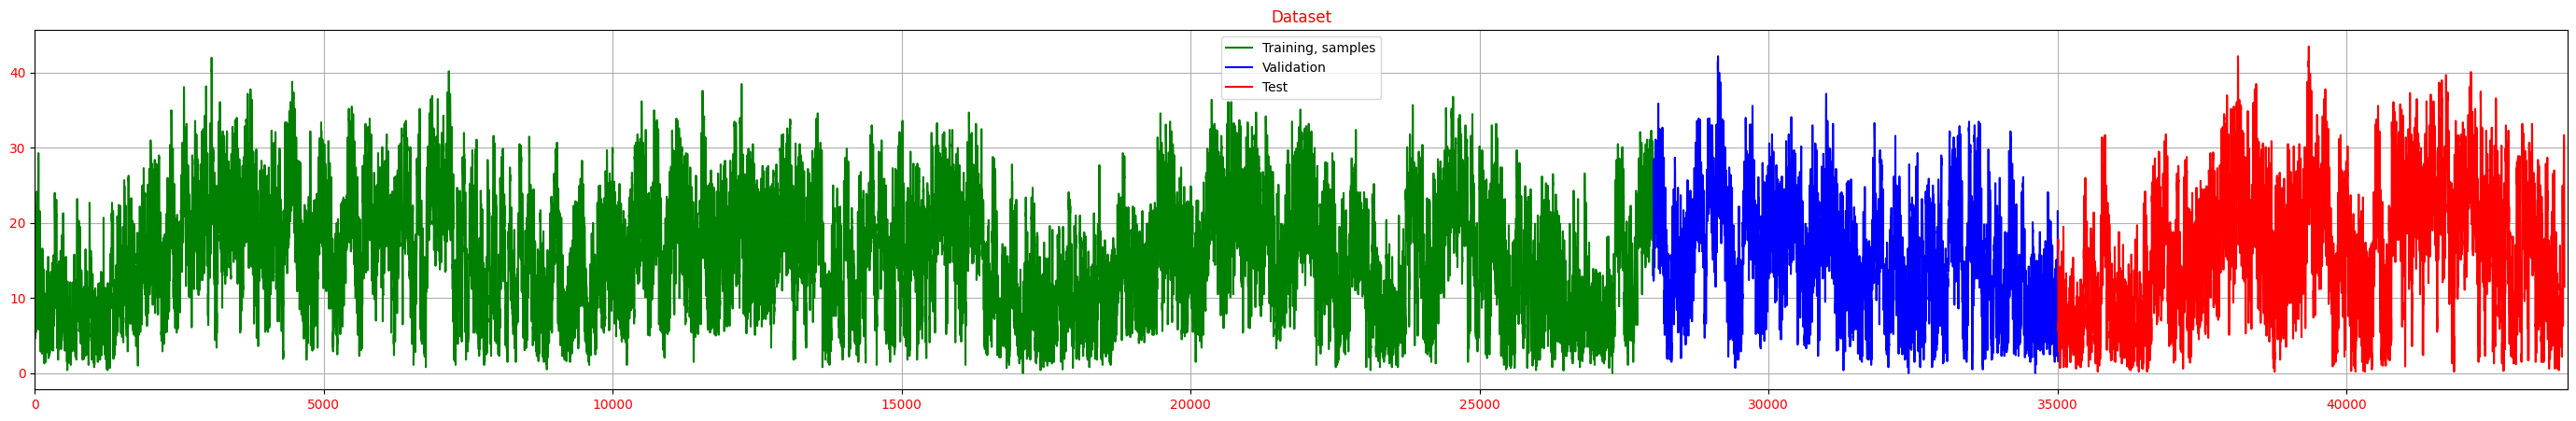

================================================ fonseca


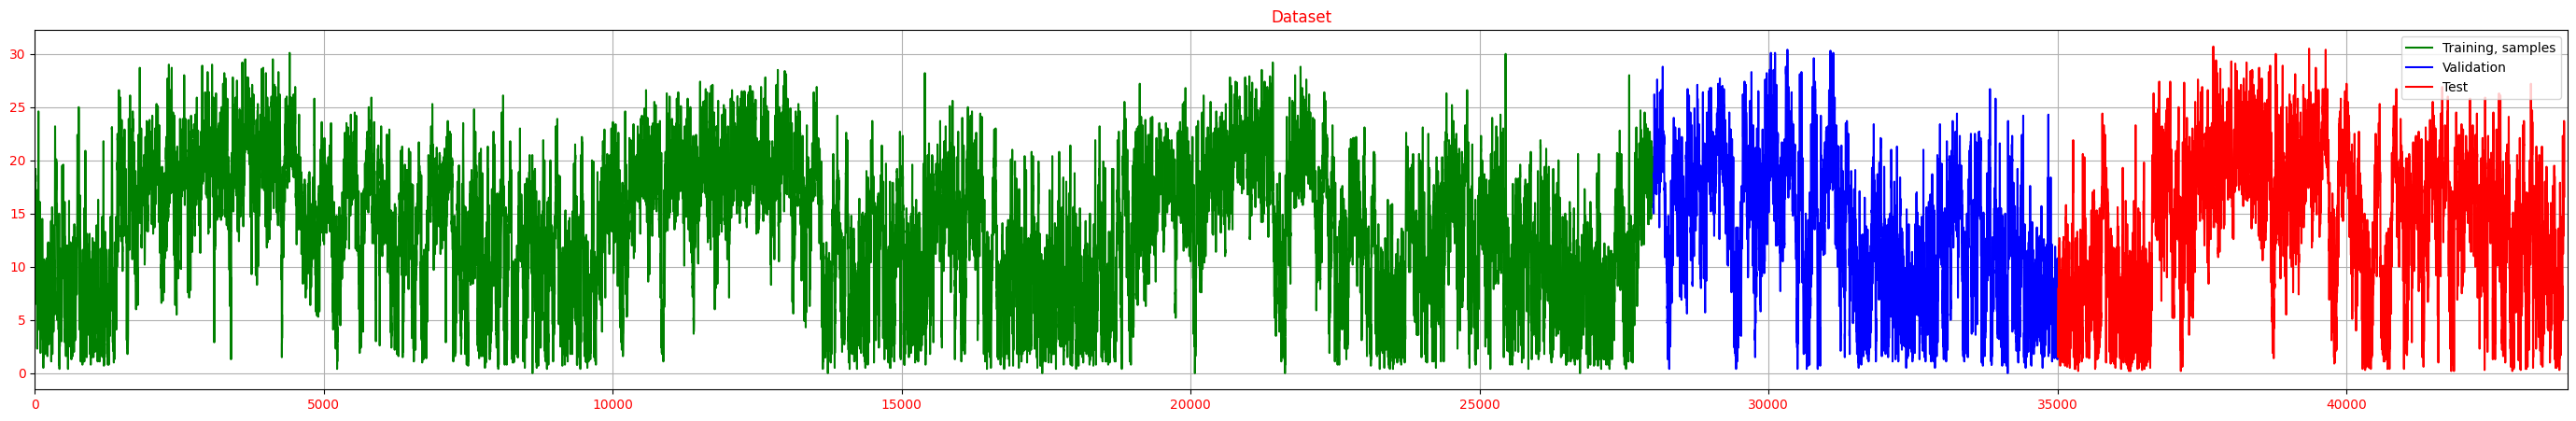

In [8]:
path = '/content/GuajiraSustainableWindBot'
datasets = os.listdir(f"{path}/data/raw/")

data = {}
for csv_file in datasets:

    name = csv_file.split('.')[0]
    name = re.sub(r'open_meteo_', '', name)

    print("======"*8, name)


    # Read dataset
    df = pd.read_csv(path + '/data/raw/' + csv_file)

    timeSerie = df['wind_speed_10m']
    time = np.arange(0, len(timeSerie),1)

    # Fill missing values
    valueMax = timeSerie.max()
    mean_value = timeSerie.mean()
    timeSerie_filled = timeSerie.fillna(mean_value)

    timeSerieNormalized = timeSerie_filled / valueMax

    # Create time series matrix
    X, y = SerieMatriz(timeSerieNormalized, predictionHorizonMax, window)

    X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    data[name] = {}
    data[name]['X_train'] = X_train
    data[name]['X_valid'] = X_valid
    data[name]['X_test'] = X_test
    data[name]['y_train'] = y_train*valueMax
    data[name]['y_valid'] = y_valid*valueMax
    data[name]['y_test'] = y_test*valueMax
    data[name]['timeSerie'] = timeSerie_filled
    data[name]['mean_value'] = mean_value
    data[name]['valueMax'] = valueMax

    # Plot dataset
    plt.figure(figsize=(35,5))
    plt.plot(time[0:X_train.shape[0]], timeSerie[0:X_train.shape[0]], 'g', label= 'Training, samples')
    plt.plot(time[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], timeSerie[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], 'b', label= 'Validation')
    plt.plot(time[X_train.shape[0]+X_valid.shape[0]:], timeSerie[X_train.shape[0]+X_valid.shape[0]:], 'r', label= 'Test')
    plt.title('Dataset', c='r')
    plt.xticks(c='r')
    plt.yticks(c='r')
    plt.xlim(0,timeSerie.shape[0])
    plt.legend()
    plt.grid(True)
    plt.show()


    os.makedirs(f'{path}/models/LSTM/{name}', exist_ok=True)

    with open(f'{path}/models/LSTM/{name}_dataset.pkl', 'wb') as f:
        pickle.dump(data, f)

# **Train model**

In [9]:
def build_model(rnn_type="LSTM", neurons=64, n_rnn_layers=3, n_dense_layers=2,
                dense_units=64, prediction_horizon=1, input_shape=[None, 1]):
    """
    rnn_type: 'LSTM', 'GRU', 'RNN'
    n_rnn_layers: nº de capas recurrentes
    n_dense_layers: nº de capas densas antes de la salida
    dense_units: nº de neuronas en cada capa densa
    """

    # Selección del tipo de capa recurrente
    if rnn_type == "LSTM":
        RNNLayer = keras.layers.LSTM
    elif rnn_type == "GRU":
        RNNLayer = keras.layers.GRU
    elif rnn_type == "RNN":
        RNNLayer = keras.layers.SimpleRNN
    else:
        raise ValueError("Tipo de red no válido. Usa 'LSTM', 'GRU' o 'RNN'.")

    model = keras.models.Sequential()

    # Capas recurrentes
    for i in range(n_rnn_layers):
        return_seq = True if i < n_rnn_layers - 1 else False
        if i == 0:
            model.add(RNNLayer(neurons, return_sequences=return_seq, input_shape=input_shape))
        else:
            model.add(RNNLayer(neurons, return_sequences=return_seq))

    # Capas densas adicionales
    for _ in range(n_dense_layers):
        model.add(keras.layers.Dense(dense_units, activation="relu"))

    # Capa de salida
    model.add(keras.layers.Dense(prediction_horizon))

    return model



In [10]:
rnn_type = "LSTM"
prediction_horizon = 12
patience = 10

================================================ la_jagua_del_pilar
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 159.6371 - mae: 10.2319 - mape: 5070314.5000 - mse: 159.6371 - r2_metric: -0.9040 - val_loss: 84.3290 - val_mae: 7.9116 - val_mape: 7091619.5000 - val_mse: 84.3290 - val_r2_metric: -0.0069
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 83.5581 - mae: 7.8627 - mape: 7210112.0000 - mse: 83.5581 - r2_metric: -0.0088 - val_loss: 84.3476 - val_mae: 7.9226 - val_mape: 7179690.0000 - val_mse: 84.3476 - val_r2_metric: -0.0072
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 85.1073 - mae: 7.9414 - mape: 8533852.0000 - mse: 85.1073 - r2_metric: -0.0101 - val_loss: 84.3270 - val_mae: 7.9154 - val_mape: 7123962.5000 - val_mse: 84.3270 - val_r2_metric: -0.0069
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 84.3617 - mae: 7.8990 - mape: 6825954.0000 - mse: 84.3617 - r2_metric: -0.0109 - val_loss: 84.3362 - val_mae: 7.9092 - val

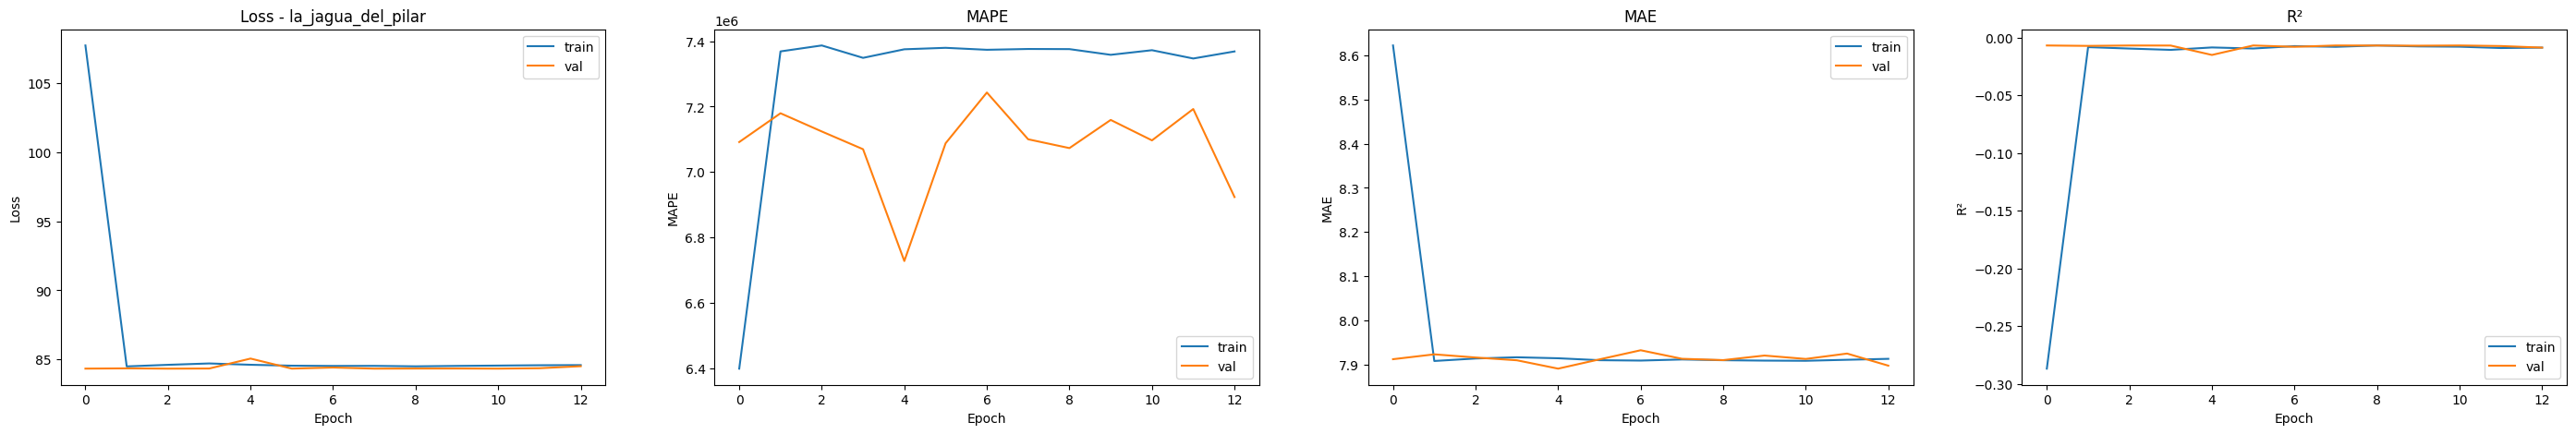

================================================ maicao
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 117.7134 - mae: 8.7746 - mape: 1264111.5000 - mse: 117.7134 - r2_metric: -1.6897 - val_loss: 44.5520 - val_mae: 5.5840 - val_mape: 1741866.3750 - val_mse: 44.5520 - val_r2_metric: -0.0086
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 44.4406 - mae: 5.5596 - mape: 2627367.2500 - mse: 44.4406 - r2_metric: -0.0092 - val_loss: 44.5968 - val_mae: 5.5903 - val_mape: 1730074.7500 - val_mse: 44.5968 - val_r2_metric: -0.0096
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 44.3098 - mae: 5.5447 - mape: 2531097.2500 - mse: 44.3098 - r2_metric: -0.0077 - val_loss: 44.6599 - val_mae: 5.5973 - val_mape: 1718494.6250 - val_mse: 44.6599 - val_r2_metric: -0.0110
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 44.3325 - mae: 5.5545 - mape: 2037960.6250 - mse: 44.3325 - r2_metric: -0.0092 - val_loss: 44.5446 - val_mae: 5.5827 - val_mape: 174454

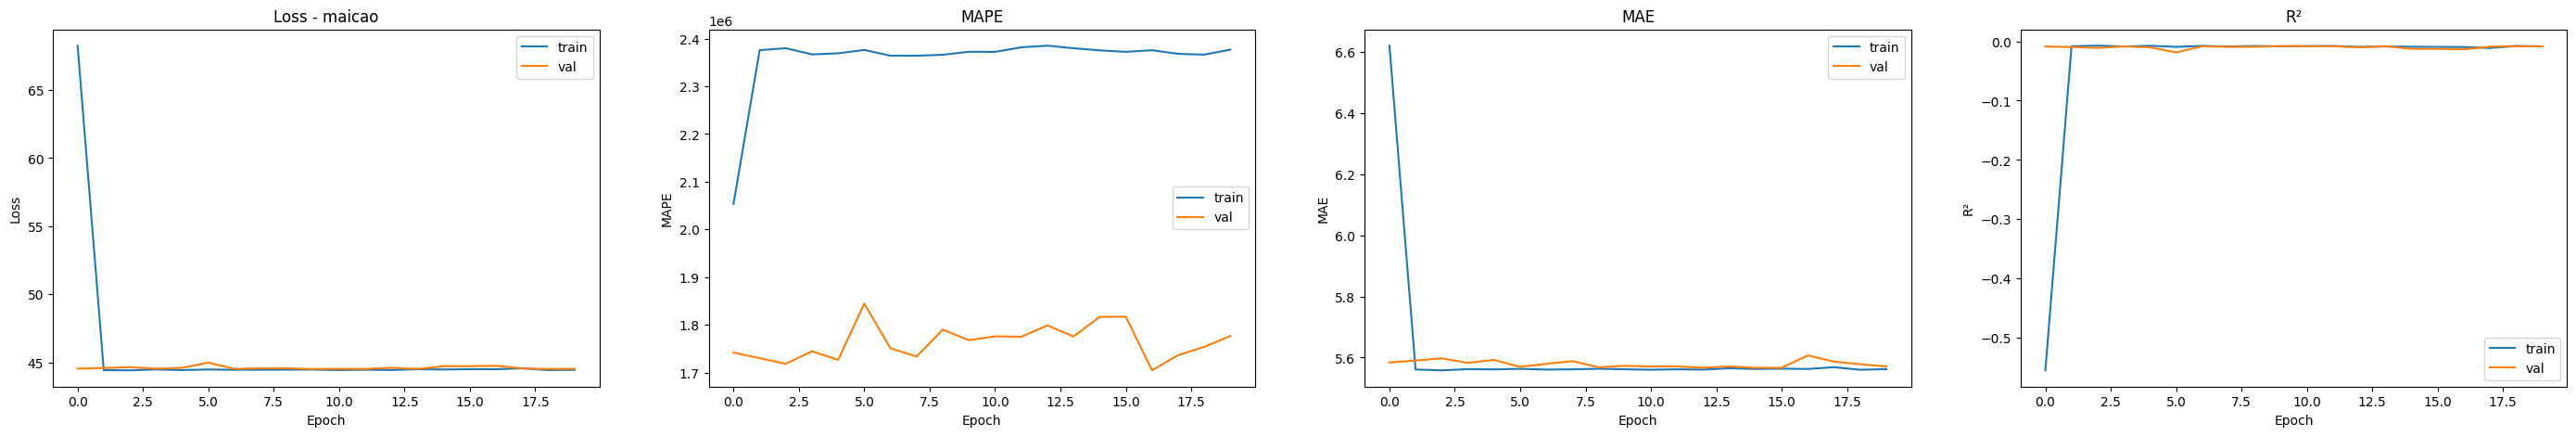

================================================ mingueo
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 52.5432 - mae: 5.6054 - mape: 3564741.7500 - mse: 52.5432 - r2_metric: -0.5380 - val_loss: 35.4870 - val_mae: 4.8437 - val_mape: 4438251.5000 - val_mse: 35.4870 - val_r2_metric: -0.0053
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 34.5329 - mae: 4.7768 - mape: 5029643.0000 - mse: 34.5329 - r2_metric: -0.0075 - val_loss: 35.5881 - val_mae: 4.7842 - val_mape: 4269949.5000 - val_mse: 35.5881 - val_r2_metric: -0.0075
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 34.5521 - mae: 4.7678 - mape: 5501264.5000 - mse: 34.5521 - r2_metric: -0.0068 - val_loss: 35.4876 - val_mae: 4.8518 - val_mape: 4458794.5000 - val_mse: 35.4876 - val_r2_metric: -0.0054
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 34.6855 - mae: 4.7895 - mape: 5441520.0000 - mse: 34.6855 - r2_metric: -0.0078 - val_loss: 35.4885 - val_mae: 4.8547 - val_mape: 4466289

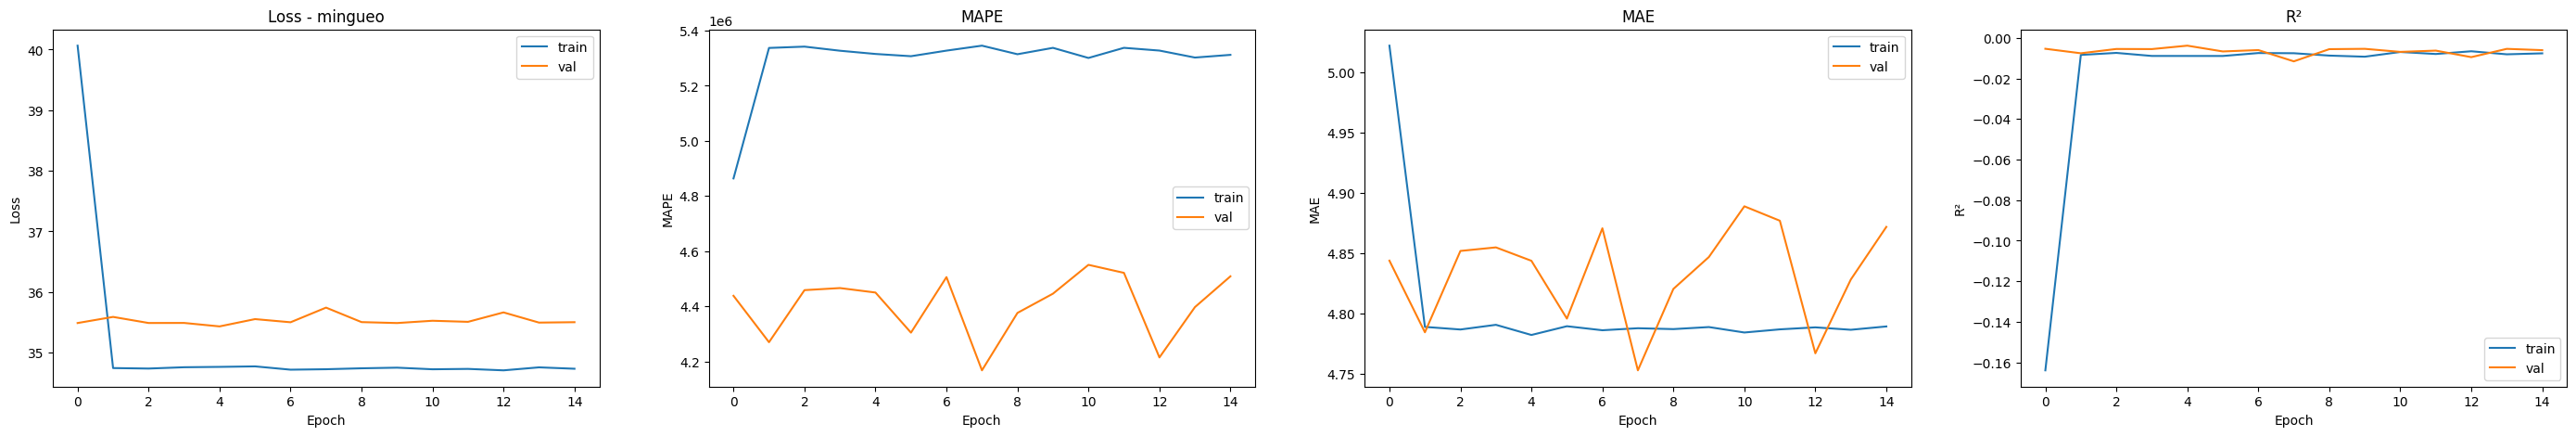

================================================ hatonuevo
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - loss: 45.1987 - mae: 5.3341 - mape: 2698049.2500 - mse: 45.1987 - r2_metric: -1.1160 - val_loss: 21.4090 - val_mae: 3.7483 - val_mape: 5361812.5000 - val_mse: 21.4090 - val_r2_metric: -0.0126
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 21.2124 - mae: 3.7596 - mape: 4932130.5000 - mse: 21.2124 - r2_metric: -0.0076 - val_loss: 21.2726 - val_mae: 3.7523 - val_mape: 5521245.0000 - val_mse: 21.2726 - val_r2_metric: -0.0064
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 21.3216 - mae: 3.7651 - mape: 3996127.5000 - mse: 21.3216 - r2_metric: -0.0075 - val_loss: 21.2683 - val_mae: 3.7530 - val_mape: 5532226.0000 - val_mse: 21.2683 - val_r2_metric: -0.0062
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 21.2253 - mae: 3.7592 - mape: 4117254.5000 - mse: 21.2253 - r2_metric: -0.0064 - val_loss: 21.2940 - val_mae: 3.7501 - val_mape: 54811

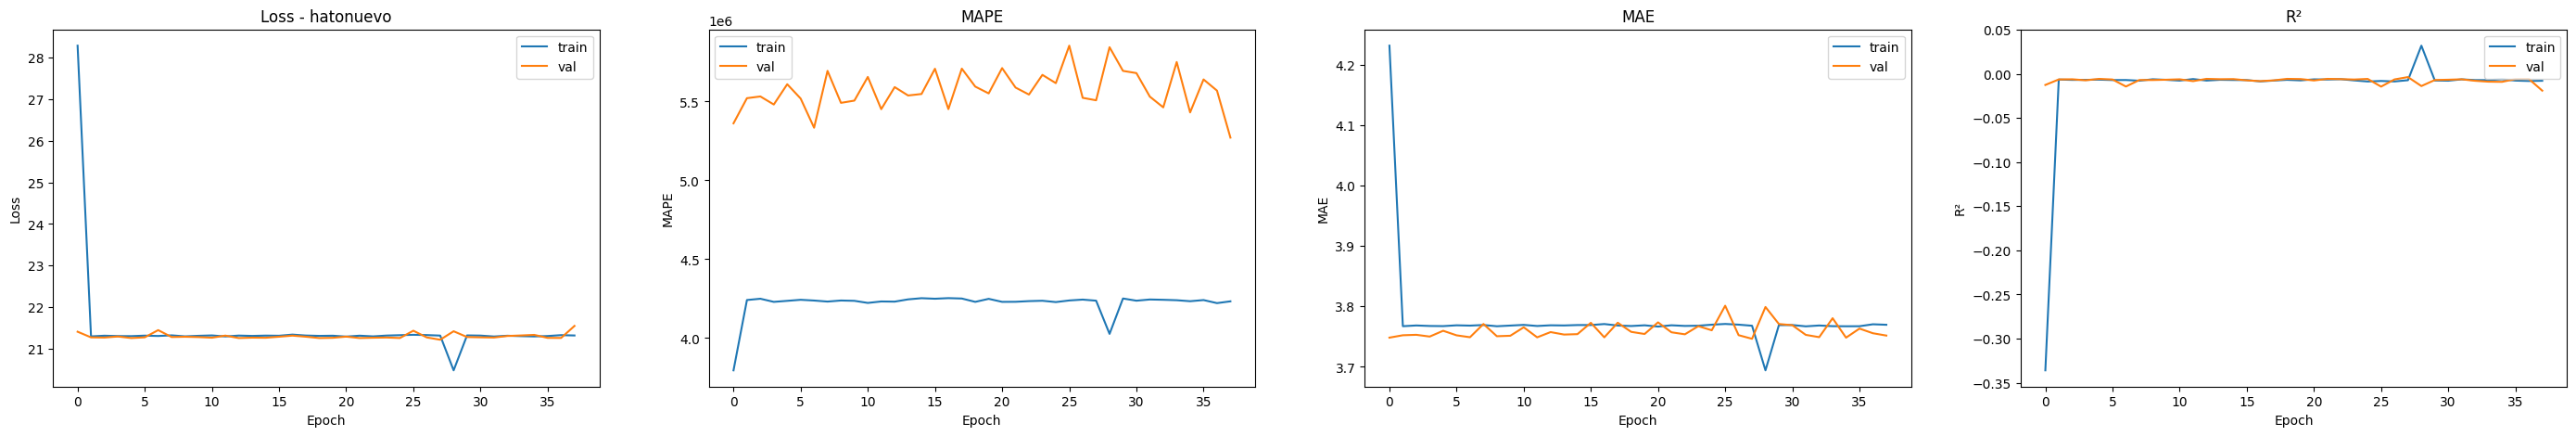

================================================ el_molino
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - loss: 117.8371 - mae: 8.7995 - mape: 2587227.2500 - mse: 117.8371 - r2_metric: -1.1777 - val_loss: 53.6708 - val_mae: 6.2812 - val_mape: 4886974.0000 - val_mse: 53.6708 - val_r2_metric: -0.0057
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 53.8930 - mae: 6.2977 - mape: 3893829.7500 - mse: 53.8930 - r2_metric: -0.0078 - val_loss: 53.6869 - val_mae: 6.2814 - val_mape: 4865632.0000 - val_mse: 53.6869 - val_r2_metric: -0.0060
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 54.3221 - mae: 6.3316 - mape: 3988397.0000 - mse: 54.3221 - r2_metric: -0.0068 - val_loss: 53.7793 - val_mae: 6.2841 - val_mape: 4799398.0000 - val_mse: 53.7793 - val_r2_metric: -0.0076
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 53.9953 - mae: 6.3163 - mape: 3626605.0000 - mse: 53.9953 - r2_metric: -0.0082 - val_loss: 53.6721 - val_mae: 6.2812 - val_mape: 488

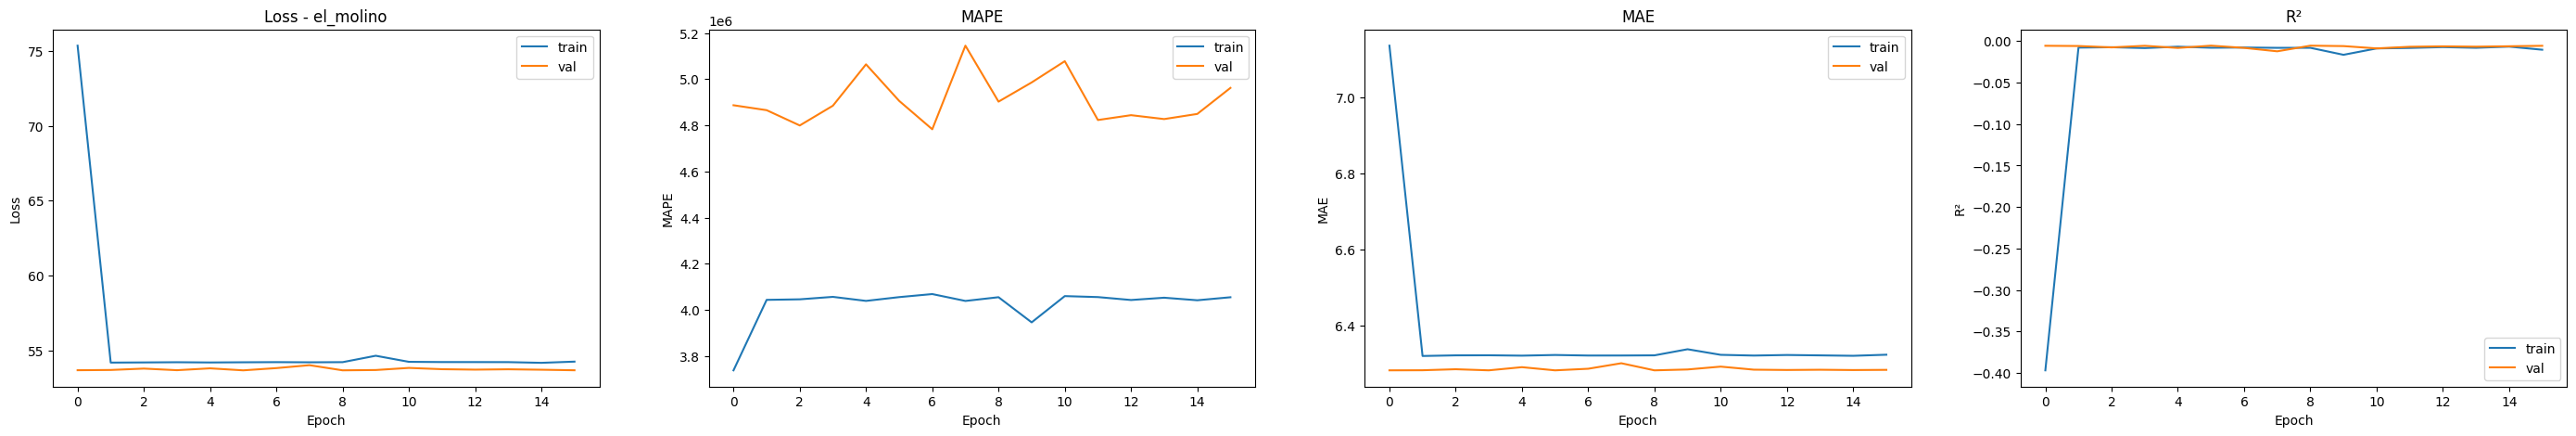

================================================ manaure
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 144.9406 - mae: 9.6531 - mape: 1059779.1250 - mse: 144.9406 - r2_metric: -1.5974 - val_loss: 56.9665 - val_mae: 6.2611 - val_mape: 1200108.7500 - val_mse: 56.9665 - val_r2_metric: -0.0094
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 56.5918 - mae: 6.2335 - mape: 1357829.3750 - mse: 56.5918 - r2_metric: -0.0058 - val_loss: 57.0849 - val_mae: 6.2540 - val_mape: 1250052.6250 - val_mse: 57.0849 - val_r2_metric: -0.0117
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 56.2998 - mae: 6.2099 - mape: 1448618.7500 - mse: 56.2998 - r2_metric: -0.0064 - val_loss: 57.0639 - val_mae: 6.2534 - val_mape: 1248276.8750 - val_mse: 57.0639 - val_r2_metric: -0.0113
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 56.8166 - mae: 6.2385 - mape: 1477606.2500 - mse: 56.8166 - r2_metric: -0.0083 - val_loss: 56.8974 - val_mae: 6.2517 - val_mape: 12214

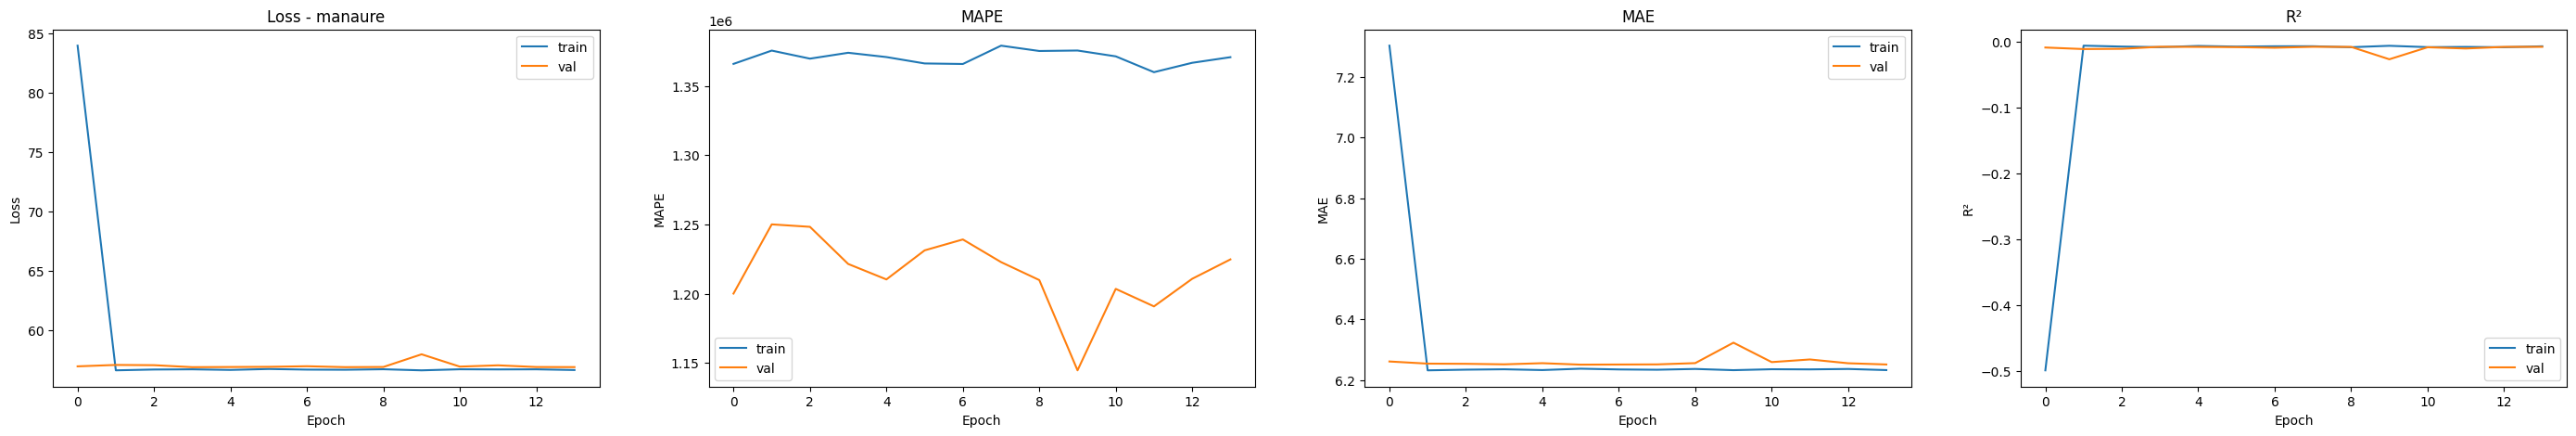

================================================ barrancas
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 81.6171 - mae: 7.3272 - mape: 1904018.6250 - mse: 81.6171 - r2_metric: -1.8596 - val_loss: 28.6066 - val_mae: 4.4481 - val_mape: 3866083.5000 - val_mse: 28.6066 - val_r2_metric: -0.0065
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 28.9448 - mae: 4.4778 - mape: 3958117.2500 - mse: 28.9448 - r2_metric: -0.0067 - val_loss: 28.6514 - val_mae: 4.4642 - val_mape: 3818840.0000 - val_mse: 28.6514 - val_r2_metric: -0.0081
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 28.8576 - mae: 4.4713 - mape: 3329483.7500 - mse: 28.8576 - r2_metric: -0.0069 - val_loss: 28.6049 - val_mae: 4.4470 - val_mape: 3869846.7500 - val_mse: 28.6049 - val_r2_metric: -0.0065
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 28.6378 - mae: 4.4401 - mape: 3058253.2500 - mse: 28.6378 - r2_metric: -0.0090 - val_loss: 28.6870 - val_mae: 4.4724 - val_mape: 37968

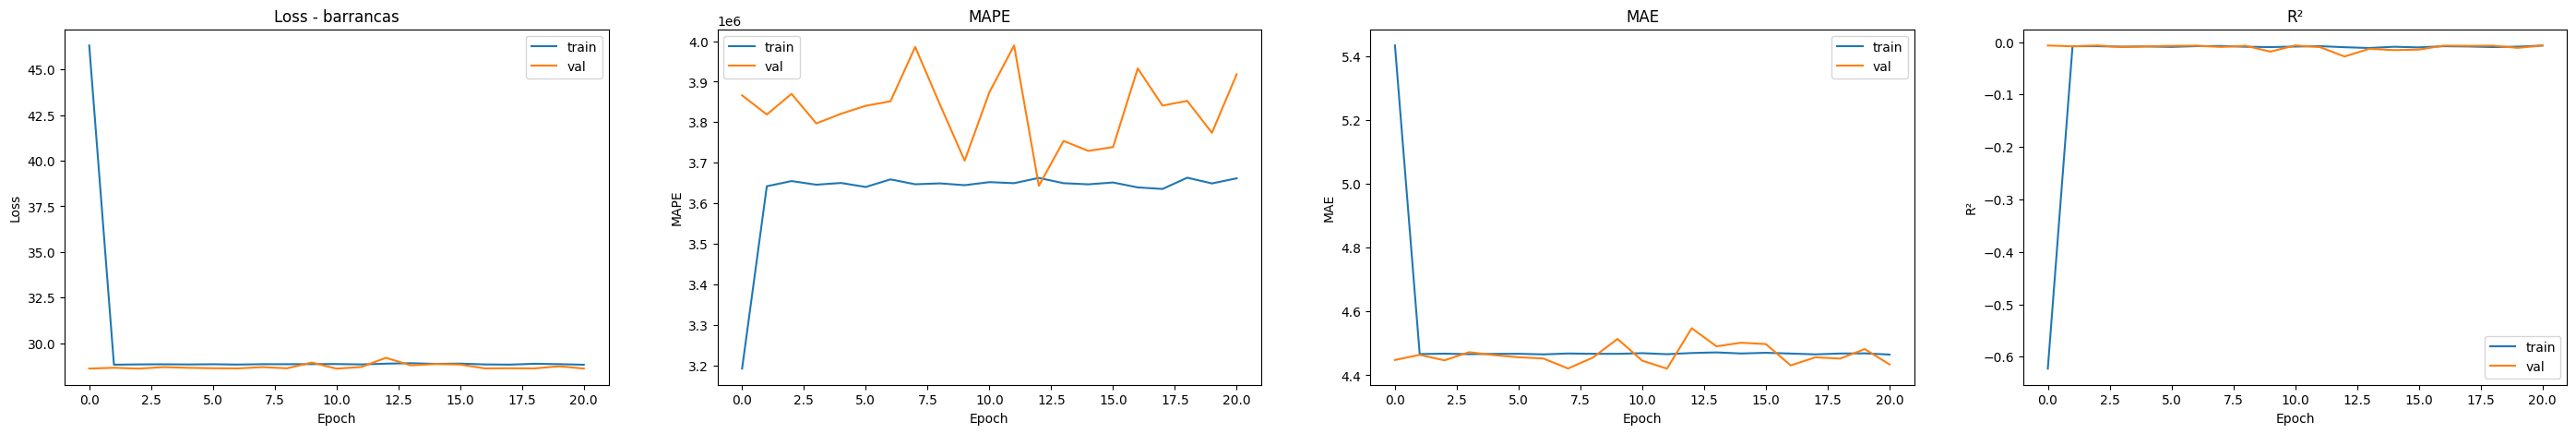

================================================ uribia
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 159.6868 - mae: 10.2737 - mape: 1374542.1250 - mse: 159.6868 - r2_metric: -1.5769 - val_loss: 62.7772 - val_mae: 6.6794 - val_mape: 4231834.5000 - val_mse: 62.7772 - val_r2_metric: -0.0084
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 62.9293 - mae: 6.6799 - mape: 2282101.5000 - mse: 62.9293 - r2_metric: -0.0050 - val_loss: 62.9195 - val_mae: 6.6872 - val_mape: 4293314.0000 - val_mse: 62.9195 - val_r2_metric: -0.0108
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 62.5811 - mae: 6.6509 - mape: 2157586.2500 - mse: 62.5811 - r2_metric: -0.0080 - val_loss: 62.7507 - val_mae: 6.6776 - val_mape: 4206567.0000 - val_mse: 62.7507 - val_r2_metric: -0.0079
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 62.0791 - mae: 6.6209 - mape: 2147544.2500 - mse: 62.0791 - r2_metric: -0.0058 - val_loss: 62.8058 - val_mae: 6.6768 - val_mape: 41174

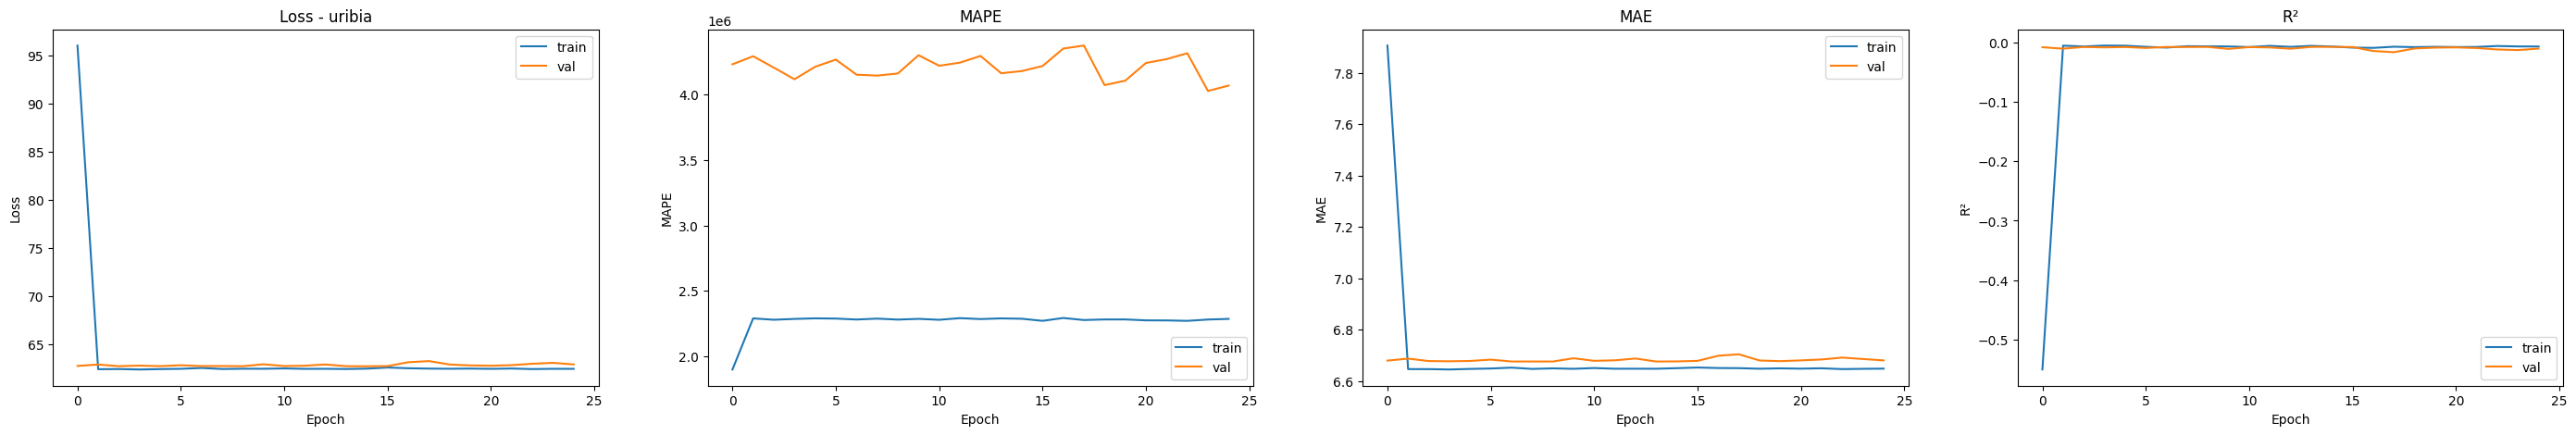

================================================ distraccion
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 94.6740 - mae: 7.8685 - mape: 1399666.3750 - mse: 94.6740 - r2_metric: -1.3493 - val_loss: 40.3558 - val_mae: 5.3638 - val_mape: 2079440.0000 - val_mse: 40.3558 - val_r2_metric: -0.0066
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 40.8696 - mae: 5.4159 - mape: 1744858.6250 - mse: 40.8696 - r2_metric: -0.0062 - val_loss: 40.5817 - val_mae: 5.4073 - val_mape: 2007971.2500 - val_mse: 40.5817 - val_r2_metric: -0.0122
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 40.7213 - mae: 5.3943 - mape: 2144799.7500 - mse: 40.7213 - r2_metric: -0.0079 - val_loss: 40.3585 - val_mae: 5.3592 - val_mape: 2089804.5000 - val_mse: 40.3585 - val_r2_metric: -0.0066
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 40.6636 - mae: 5.3959 - mape: 2043416.1250 - mse: 40.6636 - r2_metric: -0.0090 - val_loss: 40.3561 - val_mae: 5.3644 - val_mape: 207

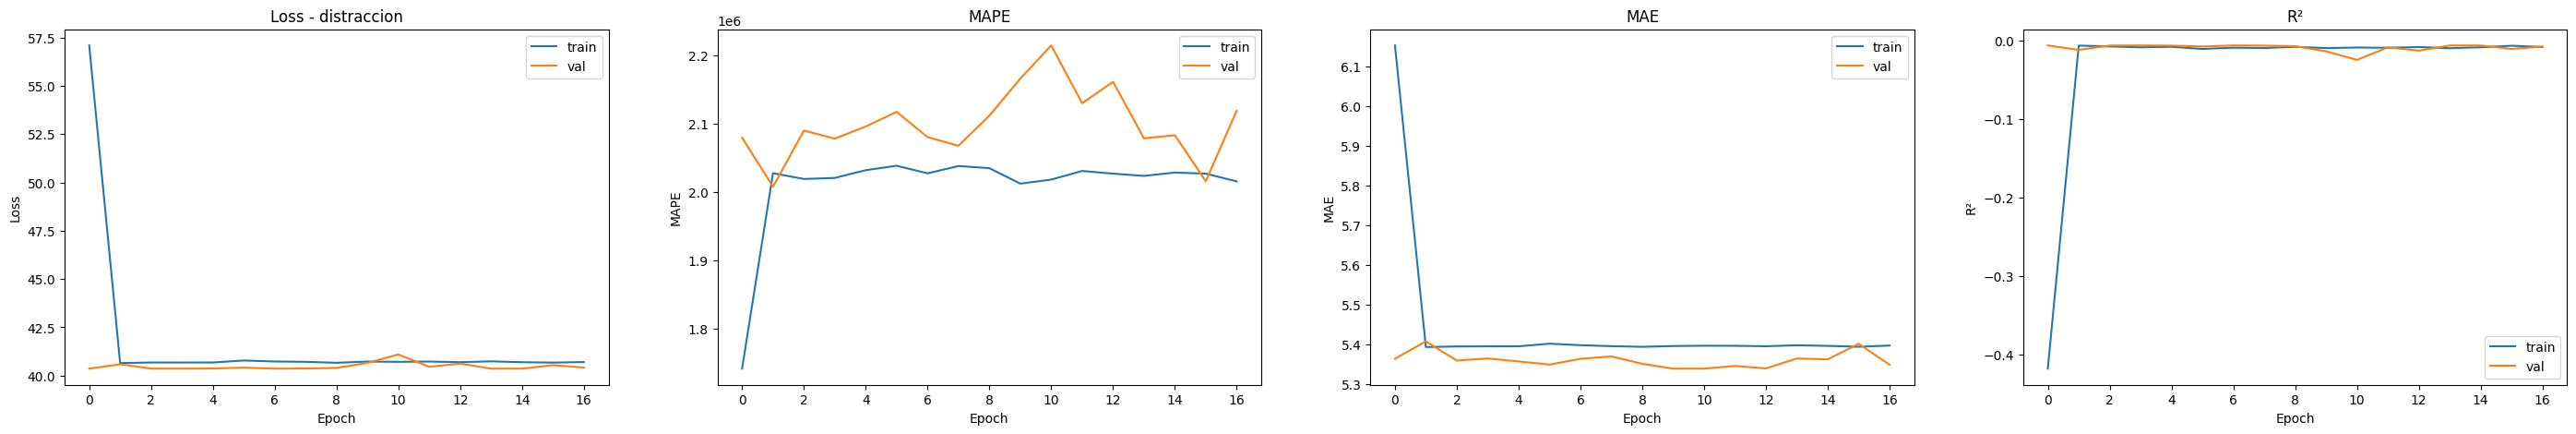

================================================ san_juan_del_cesar
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 101.0380 - mae: 8.1802 - mape: 2453691.5000 - mse: 101.0380 - r2_metric: -1.1858 - val_loss: 47.0827 - val_mae: 5.8876 - val_mape: 3905885.2500 - val_mse: 47.0827 - val_r2_metric: -0.0123
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 47.3280 - mae: 5.8681 - mape: 3851000.2500 - mse: 47.3280 - r2_metric: -0.0082 - val_loss: 46.9098 - val_mae: 5.8616 - val_mape: 3963776.2500 - val_mse: 46.9098 - val_r2_metric: -0.0086
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 47.4498 - mae: 5.8838 - mape: 3366163.2500 - mse: 47.4498 - r2_metric: -0.0102 - val_loss: 46.8641 - val_mae: 5.8081 - val_mape: 4126664.7500 - val_mse: 46.8641 - val_r2_metric: -0.0075
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 47.5840 - mae: 5.8895 - mape: 3262375.7500 - mse: 47.5840 - r2_metric: -0.0086 - val_loss: 46.9367 - val_mae: 5.8664 - val_

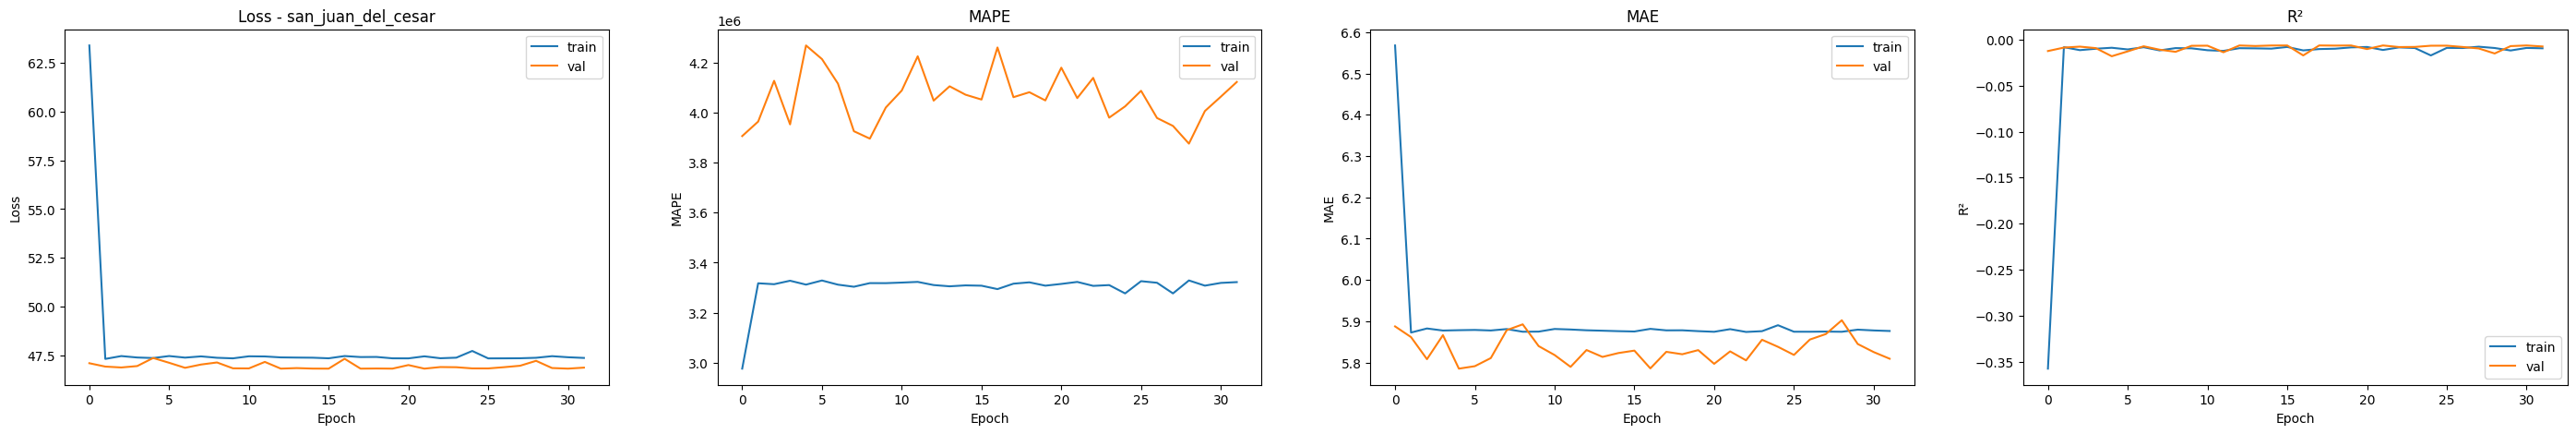

================================================ albania
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 46.9569 - mae: 5.4903 - mape: 2503502.7500 - mse: 46.9569 - r2_metric: -1.0909 - val_loss: 22.4478 - val_mae: 3.9544 - val_mape: 4402075.0000 - val_mse: 22.4478 - val_r2_metric: -0.0056
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 22.4574 - mae: 3.9625 - mape: 3855347.7500 - mse: 22.4574 - r2_metric: -0.0080 - val_loss: 22.4526 - val_mae: 3.9625 - val_mape: 4484727.0000 - val_mse: 22.4526 - val_r2_metric: -0.0059
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 22.5956 - mae: 3.9787 - mape: 3968137.7500 - mse: 22.5956 - r2_metric: -0.0057 - val_loss: 22.4890 - val_mae: 3.9512 - val_mape: 4331693.5000 - val_mse: 22.4890 - val_r2_metric: -0.0073
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 22.6433 - mae: 3.9846 - mape: 4686505.0000 - mse: 22.6433 - r2_metric: -0.0071 - val_loss: 22.4448 - val_mae: 3.9555 - val_mape: 4415290

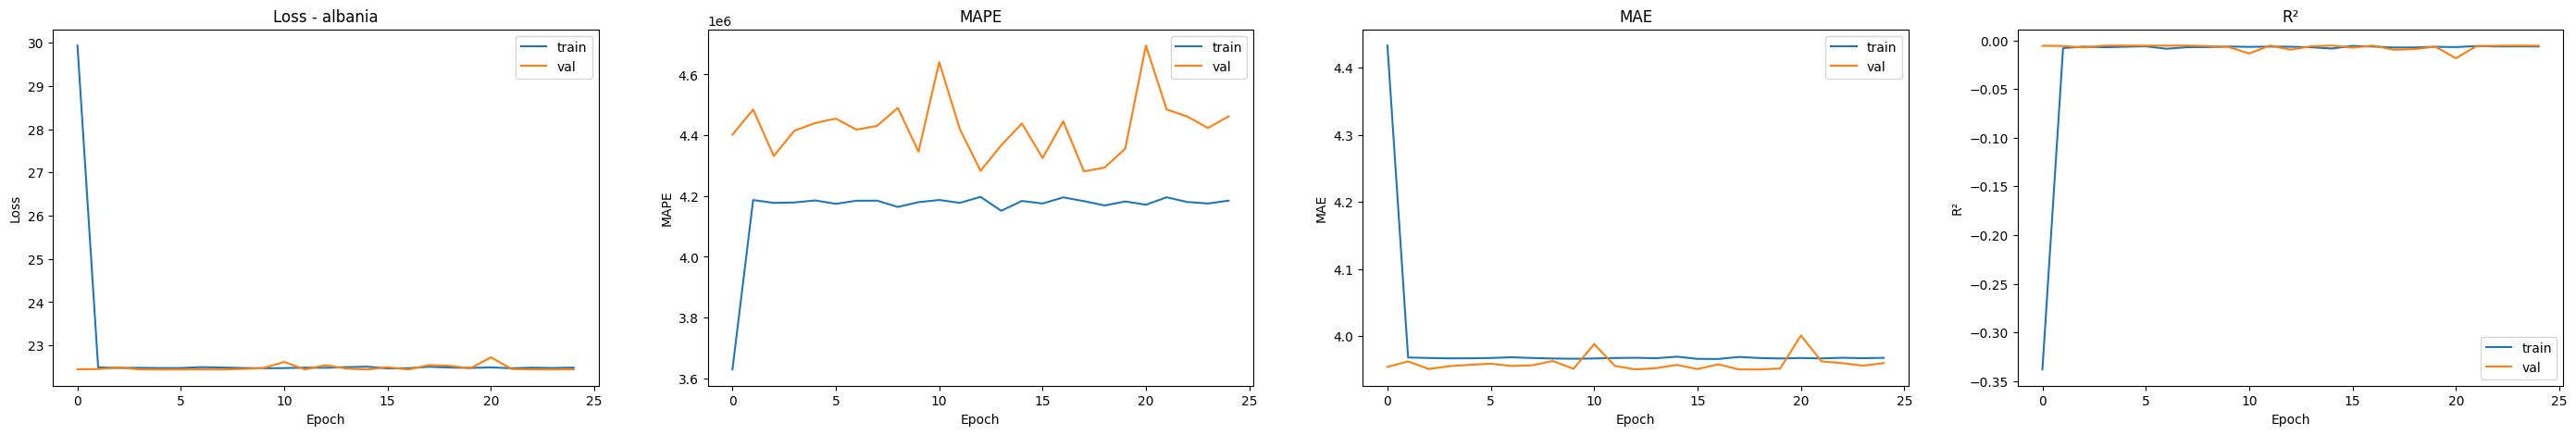

================================================ riohacha
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 145.3588 - mae: 9.6905 - mape: 987529.6250 - mse: 145.3588 - r2_metric: -1.3381 - val_loss: 62.8983 - val_mae: 6.5857 - val_mape: 1439396.5000 - val_mse: 62.8983 - val_r2_metric: -0.0083
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 62.1741 - mae: 6.5436 - mape: 1675171.0000 - mse: 62.1741 - r2_metric: -0.0054 - val_loss: 62.8235 - val_mae: 6.5900 - val_mape: 1462999.3750 - val_mse: 62.8235 - val_r2_metric: -0.0073
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 62.4442 - mae: 6.5563 - mape: 1758890.3750 - mse: 62.4442 - r2_metric: -0.0065 - val_loss: 62.8228 - val_mae: 6.5907 - val_mape: 1465199.6250 - val_mse: 62.8228 - val_r2_metric: -0.0073
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 63.2330 - mae: 6.6009 - mape: 1499957.3750 - mse: 63.2330 - r2_metric: -0.0075 - val_loss: 63.9087 - val_mae: 6.6708 - val_mape: 15647

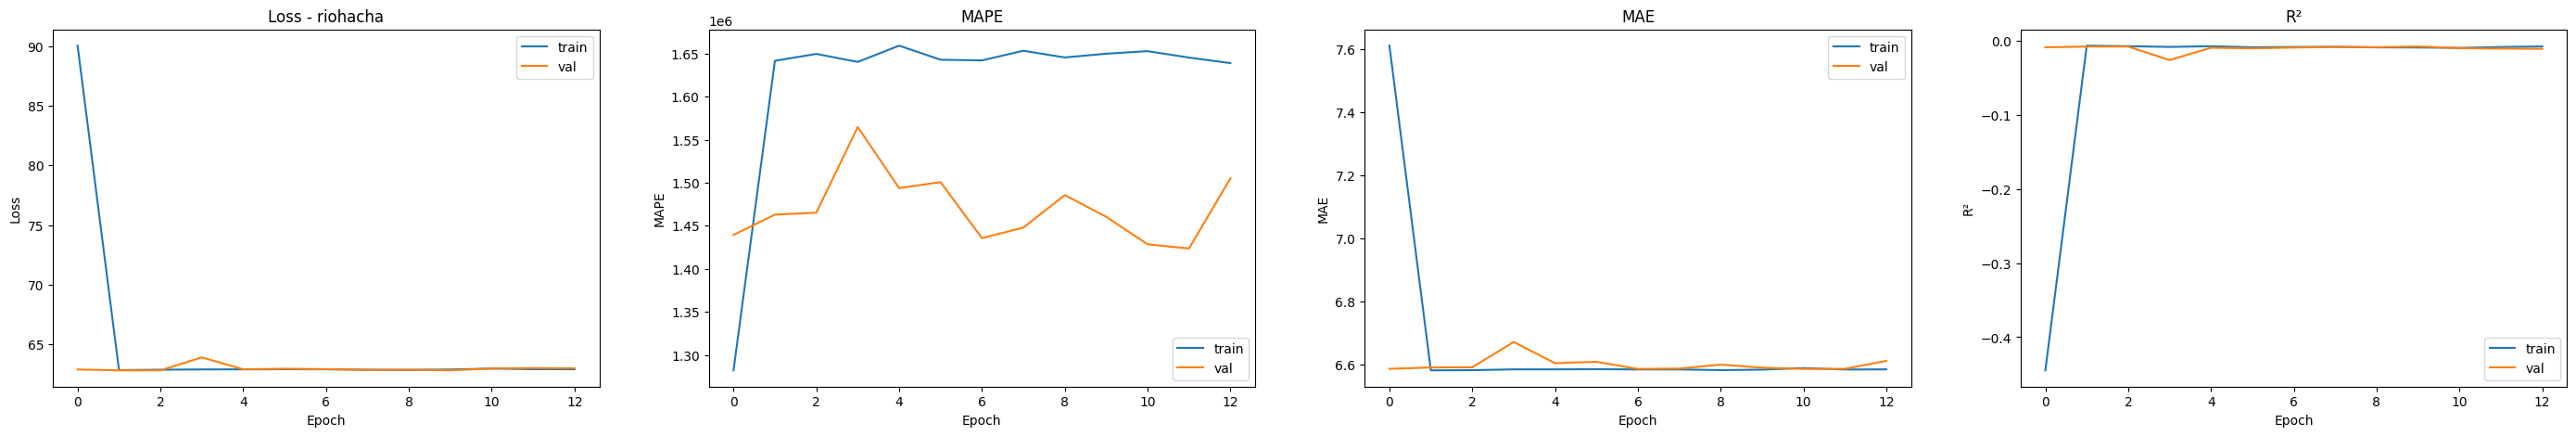

================================================ fonseca
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 99.9134 - mae: 8.1159 - mape: 1232110.8750 - mse: 99.9134 - r2_metric: -1.4753 - val_loss: 40.4738 - val_mae: 5.3928 - val_mape: 2028342.8750 - val_mse: 40.4738 - val_r2_metric: -0.0095
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 40.5751 - mae: 5.3888 - mape: 1697000.7500 - mse: 40.5751 - r2_metric: -0.0070 - val_loss: 40.4820 - val_mae: 5.3437 - val_mape: 2136543.7500 - val_mse: 40.4820 - val_r2_metric: -0.0097
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 40.8545 - mae: 5.4133 - mape: 2092547.1250 - mse: 40.8545 - r2_metric: -0.0098 - val_loss: 40.4272 - val_mae: 5.3473 - val_mape: 2122948.5000 - val_mse: 40.4272 - val_r2_metric: -0.0083
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 40.7612 - mae: 5.4030 - mape: 2389650.7500 - mse: 40.7612 - r2_metric: -0.0091 - val_loss: 40.5970 - val_mae: 5.4092 - val_mape: 2005518

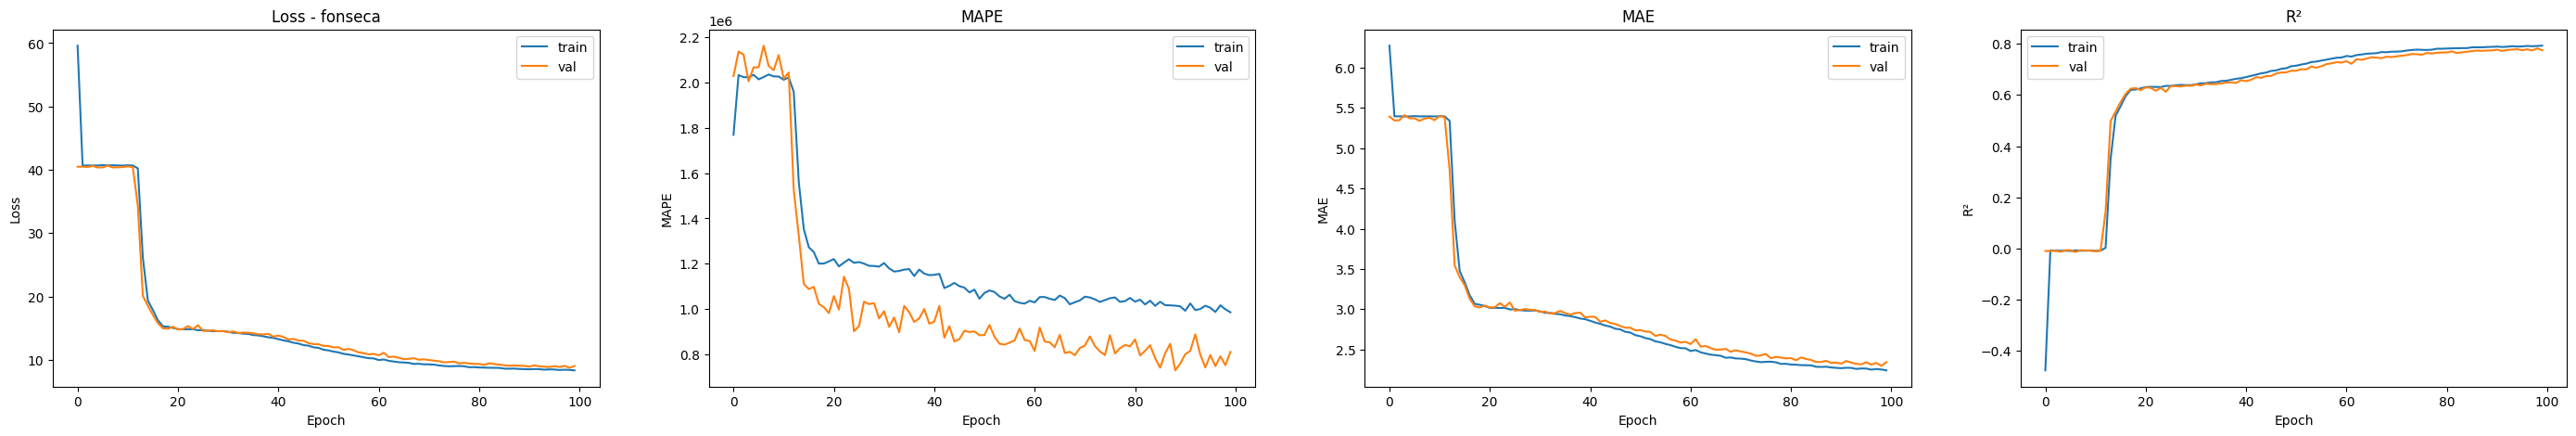

In [11]:
for name in data.keys():
  print("======"*8, name)

  # Get data
  X_train, y_train = data[name]['X_train'], data[name]['y_train']
  X_valid, y_valid = data[name]['X_valid'], data[name]['y_valid']
  X_test,  y_test  = data[name]['X_test'],  data[name]['y_test']

  # Build model
  model = build_model(rnn_type, neurons, prediction_horizon, input_shape=[X_train.shape[1], X_train.shape[2]])

  # Compile
  model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['mae','mse','mape', r2_metric])  # 👈 añadimos R²

  # Early stopping con seguimiento de val_loss
  early_stop = keras.callbacks.EarlyStopping(
      monitor="val_loss",
      patience=patience,
      restore_best_weights=True
  )

  # Train
  history = model.fit(
      X_train, y_train,
      epochs=epochs,
      batch_size=batch_size,
      validation_data=(X_valid, y_valid),
      callbacks=[early_stop],
      verbose=1
  )

  # Plot training curves
  plt.figure(figsize=(35,5))

  plt.subplot(1, 4, 1)
  plt.title(f"Loss - {name}")
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('Epoch'); plt.ylabel('Loss')
  plt.legend(['train', 'val'])

  plt.subplot(1, 4, 2)
  plt.title("MAPE")
  plt.plot(history.history['mape'])
  plt.plot(history.history['val_mape'])
  plt.xlabel('Epoch'); plt.ylabel('MAPE')
  plt.legend(['train','val'])

  plt.subplot(1, 4, 3)
  plt.title("MAE")
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.xlabel('Epoch'); plt.ylabel('MAE')
  plt.legend(['train','val'])

  plt.subplot(1, 4, 4)
  plt.title("R²")
  plt.plot(history.history['r2_metric'])
  plt.plot(history.history['val_r2_metric'])
  plt.xlabel('Epoch'); plt.ylabel('R²')
  plt.legend(['train','val'])

  plt.show()

  # Evaluation en test
  """
  forecasting = model.predict(X_test)
  col_names, MSE, RMSE, MAE, R2 = ['Metrics'], ["MSE"], ["RMSE"], ["MAE"], ["R2"]

  for k in range(prediction_horizon):
      col_names.append(str(k+1))
      MSE.append(round(mean_squared_error(y_test[:,k], forecasting[:,k]), 3))
      RMSE.append(round(np.sqrt(mean_squared_error(y_test[:,k], forecasting[:,k])), 3))
      MAE.append(round(mean_absolute_error(y_test[:,k], forecasting[:,k]), 3))
      R2.append(round(r2_score(y_test[:,k], forecasting[:,k]), 3))

  metrics = [MSE, RMSE, MAE, R2]
  print(tabulate(metrics, headers=col_names, tablefmt="fancy_grid"))
  """

  # Save model
  model.save(f'{path}/models/{rnn_type}/{name}_model.keras')

  # Save history
  with open(f'{path}/models/{rnn_type}/{name}_history.pkl', 'wb') as f:
      pickle.dump(history.history, f)


In [13]:
!pwd

/content/GuajiraSustainableWindBot


In [14]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/LSTM/ (stored 0%)
  adding: models/LSTM/la_jagua_del_pilar_model.keras (deflated 14%)
  adding: models/LSTM/uribia_dataset.pkl (deflated 81%)
  adding: models/LSTM/mingueo_model.keras (deflated 14%)
  adding: models/LSTM/uribia_model.keras (deflated 14%)
  adding: models/LSTM/mingueo_history.pkl (deflated 57%)
  adding: models/LSTM/hatonuevo_history.pkl (deflated 62%)
  adding: models/LSTM/albania_history.pkl (deflated 61%)
  adding: models/LSTM/barrancas_model.keras (deflated 14%)
  adding: models/LSTM/distraccion_history.pkl (deflated 58%)
  adding: models/LSTM/riohacha/ (stored 0%)
  adding: models/LSTM/manaure_model.keras (deflated 14%)
  adding: models/LSTM/distraccion_dataset.pkl (deflated 81%)
  adding: models/LSTM/hatonuevo_model.keras (deflated 15%)
  adding: models/LSTM/hatonuevo/ (stored 0%)
  adding: models/LSTM/barrancas_dataset.pkl (deflated 81%)
  adding: models/LSTM/san_juan_del_cesar_history.pkl (deflated 61%)
  adding: mo